In [1]:
file_tag = "COVID-19"
filename = "data/time_series/forecast_covid_single.csv"
index = "date"
target = "deaths"
timecol = "date"

In [37]:
file_tag = "Traffic"
filename = "data/time_series/forecast_traffic_single.csv"
index = "Timestamp"
target = "Total"
timecol = "Timestamp"

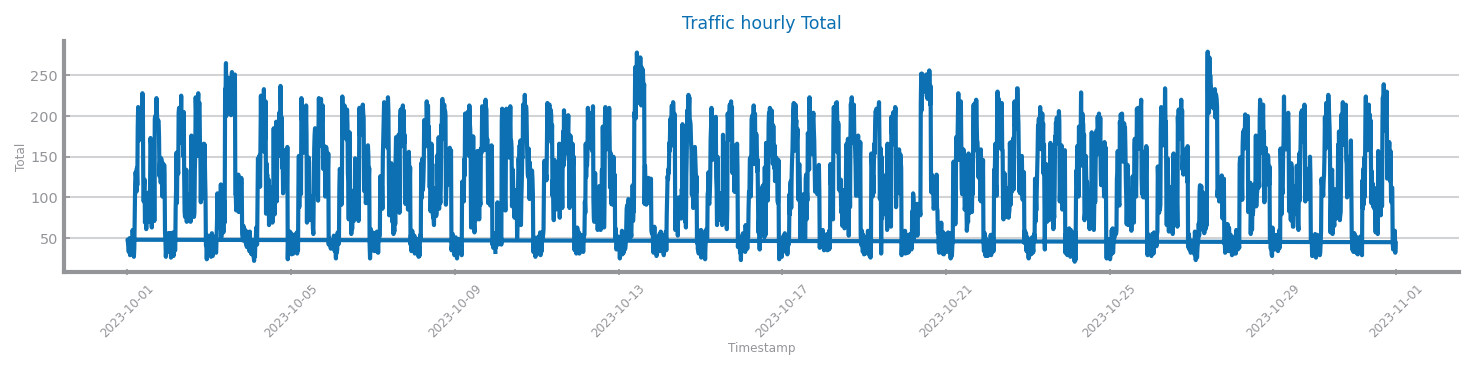

In [38]:
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import figure, show, savefig
from dslabs_functions import plot_line_chart, HEIGHT

data: DataFrame = read_csv(
    filename,
    index_col=index,
    sep=",",
    decimal=".",
    parse_dates=True,
    infer_datetime_format=True,
)
series: Series = data[target]

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    series.index.to_list(),
    series.to_list(),
    xlabel=series.index.name,
    ylabel=target,
    title=f"{file_tag} hourly {target}",
)
show()

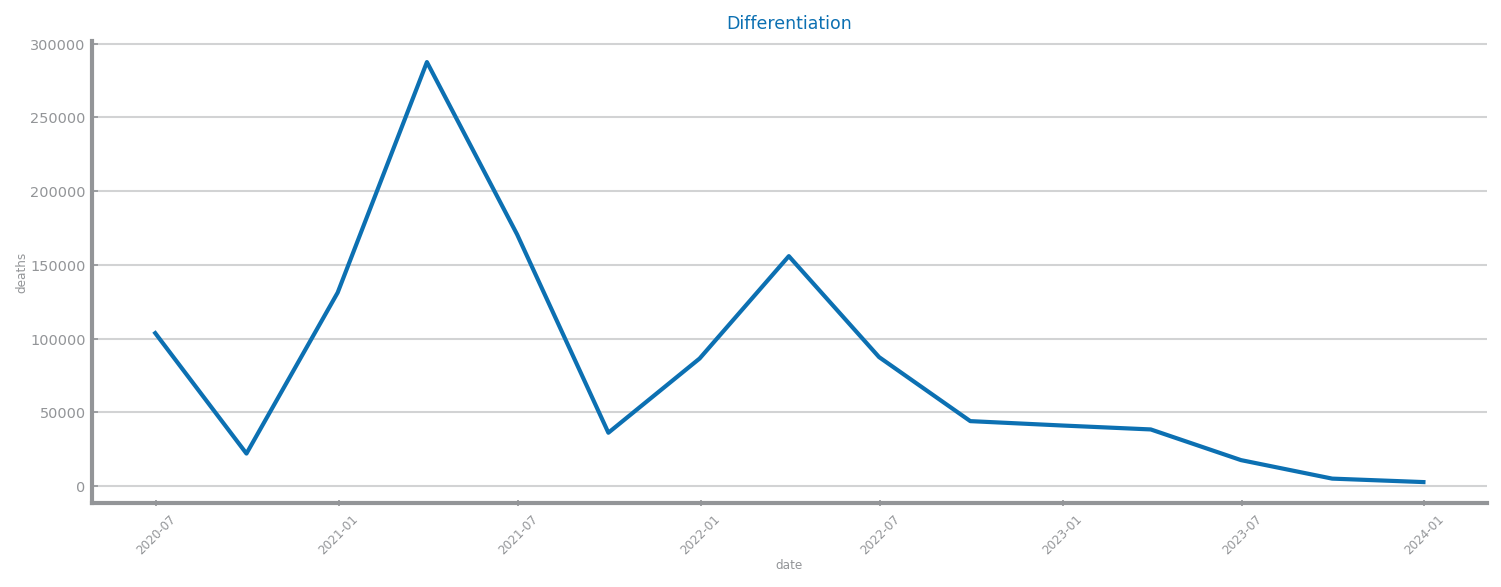

In [3]:
from dslabs_functions import plot_line_chart

ss_week: Series = series
ss_month: Series = series.resample("M").mean()
ss_quarter: Series = series.resample("Q").mean()
ss_year: Series = series.resample("Y").mean()



ss_diff: Series = ss_quarter.diff()
figure(figsize=(3 * HEIGHT, HEIGHT))
plot_line_chart(
    ss_diff.index.to_list(),
    ss_diff.to_list(),
    title="Differentiation",
    xlabel=series.index.name,
    ylabel=target,
)
# savefig(f"images/{file_tag}_yearly_{target}_diff.png")
show()

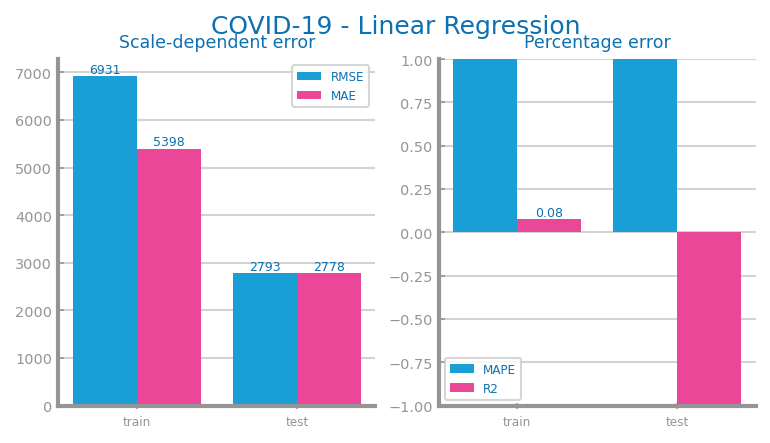

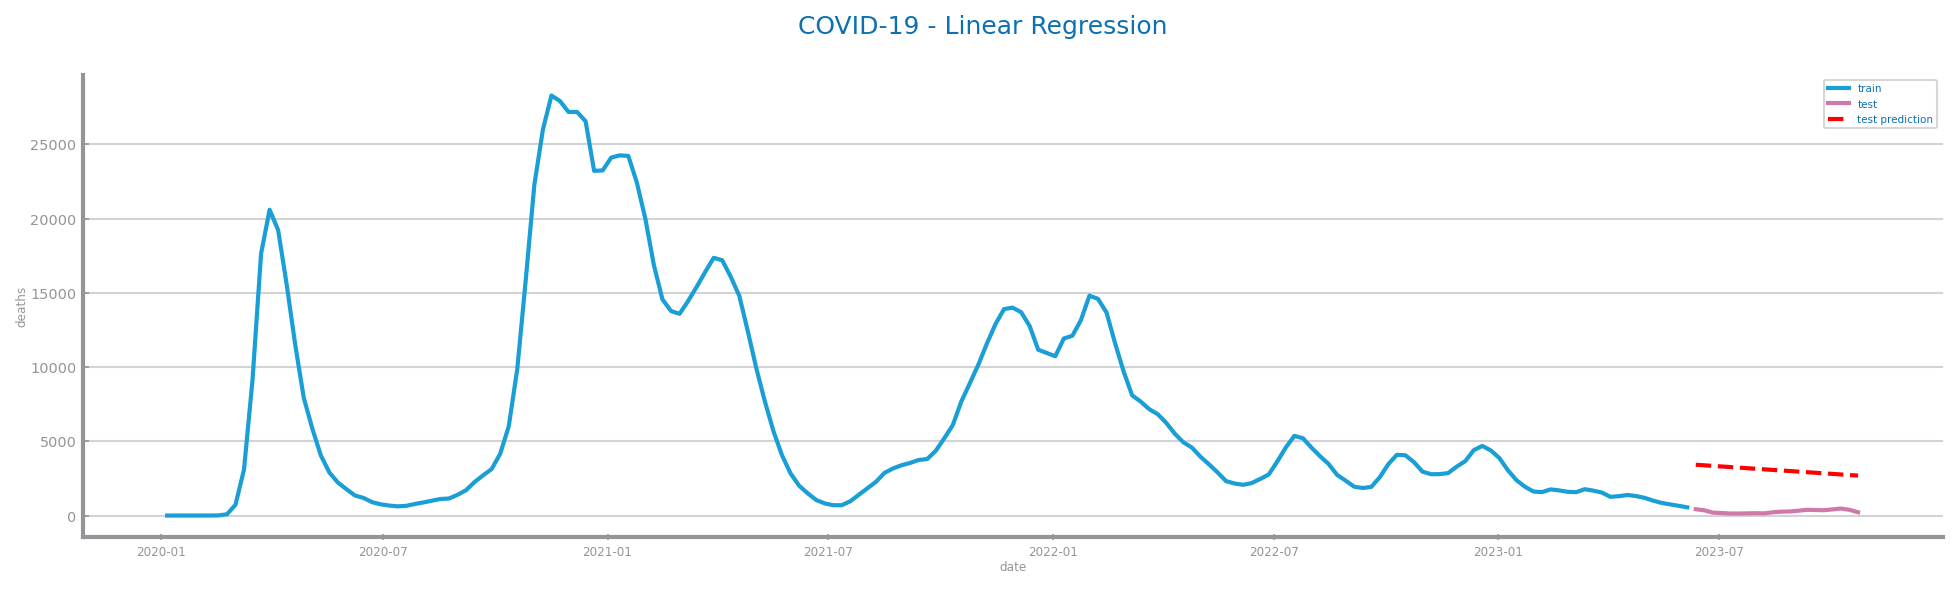

In [4]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split, plot_forecasting_eval


data: DataFrame = read_csv(filename, index_col=timecol, sep=",", decimal=".", parse_dates=True)
series: Series = data[target]


agg_df = data
# agg_df = agg_df.resample("M").mean()
agg_df = agg_df.diff()
agg_df = agg_df.fillna(0)
train, test = series_train_test_split(agg_df, trn_pct=0.90)

trnX = arange(len(train)).reshape(-1, 1)
trnY = train.to_numpy()
tstX = arange(len(train), len(data)).reshape(-1, 1)
tstY = test.to_numpy()

model = LinearRegression()
model.fit(trnX, trnY)

prd_trn: Series = Series(model.predict(trnX), index=train.index)
prd_tst: Series = Series(model.predict(tstX), index=test.index)

plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Linear Regression")
savefig(f"images/{file_tag}_linear_regression_eval.png")

from dslabs_functions import plot_forecasting_series

plot_forecasting_series(
    train,
    test,
    prd_tst,
    title=f"{file_tag} - Linear Regression",
    xlabel=timecol,
    ylabel=target,
)
savefig(f"images/{file_tag}_linear_regression_forecast.png")

In [5]:
def bla(agg_df):
    train, test = series_train_test_split(agg_df, trn_pct=0.90)

    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(agg_df)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX), index=train.index)
    prd_tst: Series = Series(model.predict(tstX), index=test.index)

    return train, test, prd_trn, prd_tst

In [6]:
from matplotlib.axes import Axes
from matplotlib.pyplot import subplots
from numpy import sqrt
from config import FUTURE_COLOR, PAST_COLOR, PRED_FUTURE_COLOR
from dslabs_functions import FORECAST_MEASURES, plot_multibar_chart


def plot_forecasting_eval(trn: Series, tst: Series, prd_trn: Series, prd_tst: Series, title: str = "", axs = None) -> list[Axes]:
    ev1: dict = {
        "RMSE": [sqrt(FORECAST_MEASURES["MSE"](trn, prd_trn)), sqrt(FORECAST_MEASURES["MSE"](tst, prd_tst))],
        "MAE": [FORECAST_MEASURES["MAE"](trn, prd_trn), FORECAST_MEASURES["MAE"](tst, prd_tst)],
    }
    ev2: dict = {
        "MAPE": [FORECAST_MEASURES["MAPE"](trn, prd_trn), FORECAST_MEASURES["MAPE"](tst, prd_tst)],
        "R2": [FORECAST_MEASURES["R2"](trn, prd_trn), FORECAST_MEASURES["R2"](tst, prd_tst)],
    }

    # print(eval1, eval2)
    if axs is None:
        fig, axs = subplots(1, 2, figsize=(1.5 * HEIGHT, 0.75 * HEIGHT), squeeze=True)
        fig.suptitle(title)
    else:
        axs[0].set_title(title)
    plot_multibar_chart(["train", "test"], ev1, ax=axs[0], title=f"Scale-dependent error ({title})", percentage=False)
    plot_multibar_chart(["train", "test"], ev2, ax=axs[1], title=f"Percentage error ({title})", percentage=True)

    return axs

def plot_forecasting_series(
    trn: Series,
    tst: Series,
    prd_tst: Series,
    title: str = "",
    xlabel: str = "time",
    ylabel: str = "",
    ax = None
) -> list[Axes]:
    if ax is None:
        fig, ax = subplots(1, 1, figsize=(4 * HEIGHT, HEIGHT), squeeze=True)
        fig.suptitle(title)
    else:
        ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.plot(trn.index, trn.values, label="train", color=PAST_COLOR)
    ax.plot(tst.index, tst.values, label="test", color=FUTURE_COLOR)
    ax.plot(prd_tst.index, prd_tst.values, "--", label="test prediction", color=PRED_FUTURE_COLOR)
    ax.legend(prop={"size": 5})

    return ax

In [7]:
import os
# for file in os.listdir("images"):
#     if file.endswith(".png"):
#         os.remove(f"images/{file}")

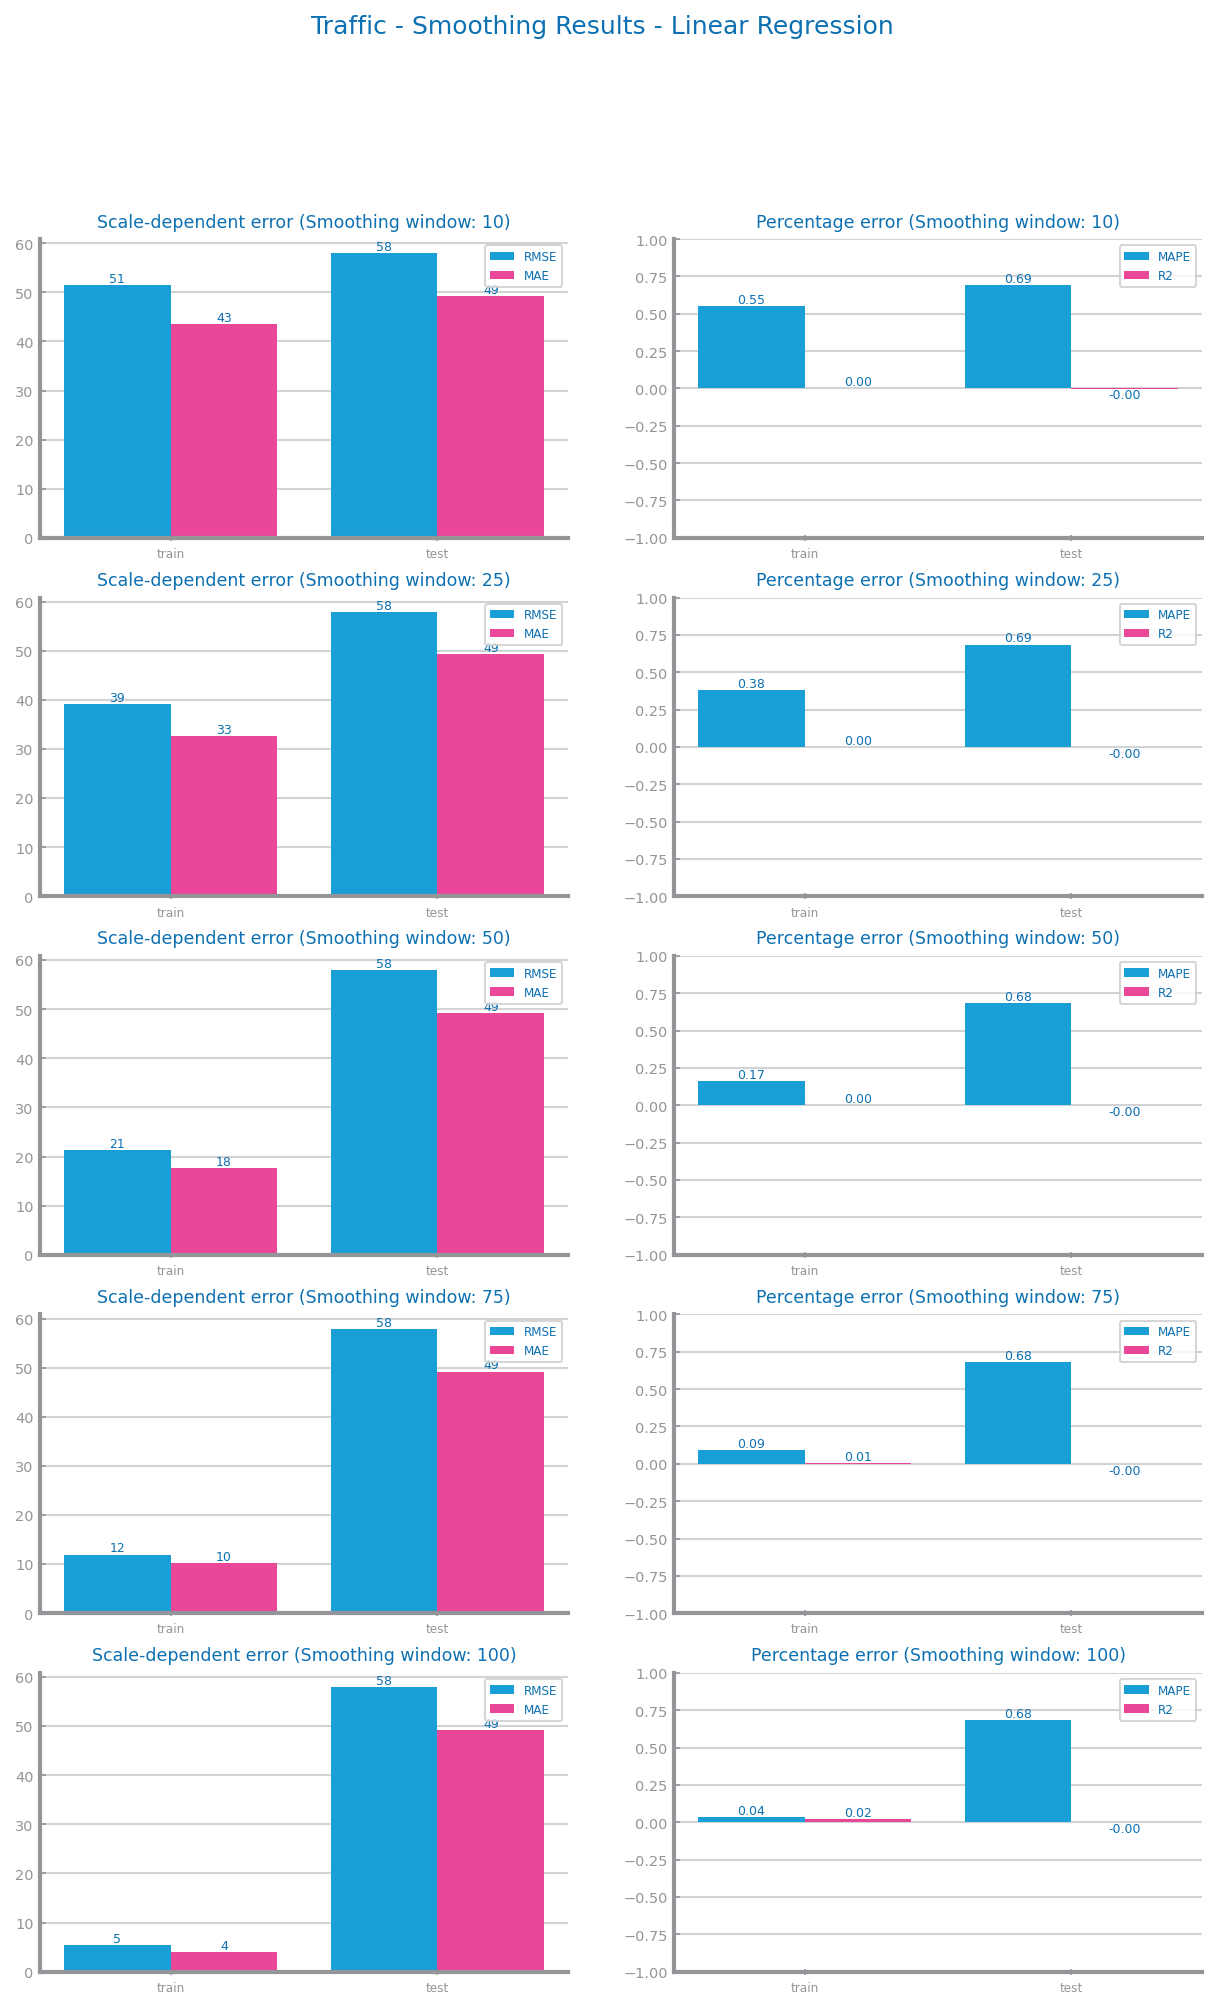

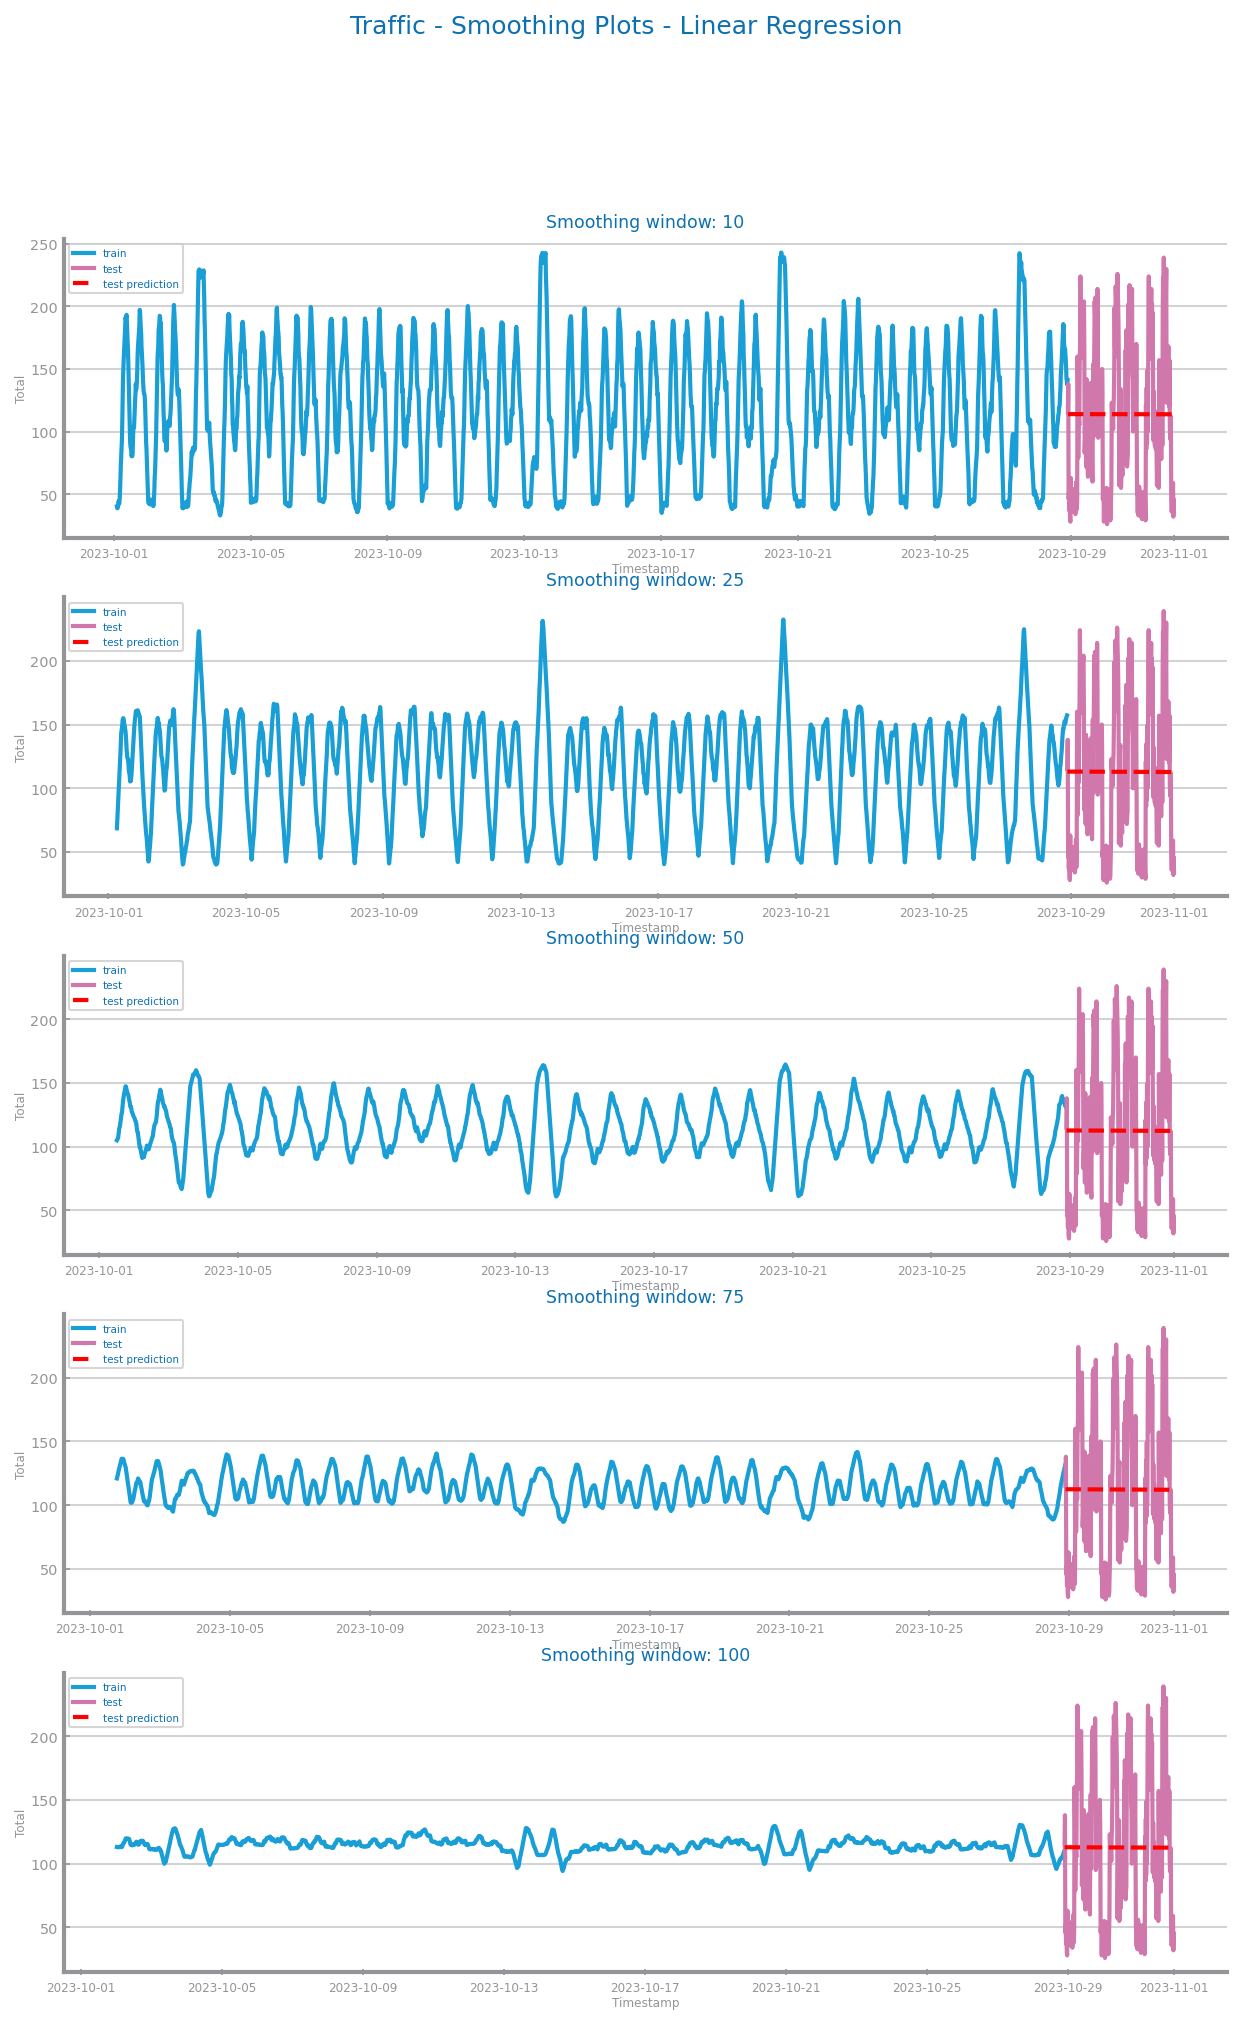

In [42]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split, ts_aggregation_by

from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure

fig: Figure
axs: list[Axes]

## bests W, 50
## Q, 10

def bla2(train, test):
    trnX = arange(len(train)).reshape(-1, 1)
    trnY = train.to_numpy()
    tstX = arange(len(train), len(train) + len(test)).reshape(-1, 1)
    tstY = test.to_numpy()

    model = LinearRegression()
    model.fit(trnX, trnY)

    prd_trn: Series = Series(model.predict(trnX), index=train.index)
    prd_tst: Series = Series(model.predict(tstX), index=test.index)

    return train, test, prd_trn, prd_tst

sizes: list[int] = [10, 25, 50, 75, 100]

# data.index.freq = '15T'
data.sort_index(inplace=True)

for aggr in ["W", "M", "Q"]:
    # agg_df: DataFrame = ts_aggregation_by(data, gran_level=aggr, agg_func="mean")
    agg_df = data
    # for roll in [10, 25, 50, 75, 100]:

    fig, axs = subplots(nrows=len(sizes), ncols=2, figsize=(10, 15))
    fig.suptitle(f"{file_tag} - Smoothing Results - Linear Regression")
    for i in range(len(sizes)):
        # if sizes[i] != 0:
        #     scrt = scrt.diff()

        # scrt.fillna(0, inplace=True)
        
        train, test = series_train_test_split(agg_df, trn_pct=0.90)

        train = train.rolling(window=sizes[i]).mean()
        # train = train.fillna(0, inplace=False)
        train = train.dropna()

        # train, test, prd_trn, prd_tst = bla(scrt)
        train, test, prd_trn, prd_tst = bla2(train, test)
        plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"Smoothing window: {sizes[i]}", axs=axs[i])
        
        # try:
        #     print(train)
        # except Exception as e:
        #     print(f"Smoothing window: {sizes[i]}", e)
    savefig(f"images/{file_tag}_linear_regression_eval_{aggr}.png", bbox_inches='tight')


    fig, axs = subplots(nrows=len(sizes), ncols=1, figsize=(10, 15))
    fig.suptitle(f"{file_tag} - Smoothing Plots - Linear Regression")
    for i in range(len(sizes)):
        # scrt = agg_df.rolling(window=sizes[i]).mean()

        # if sizes[i] != 0:
        #     scrt = scrt.diff()

        # scrt.fillna(0, inplace=True)
        
        train, test = series_train_test_split(agg_df, trn_pct=0.90)

        train = train.rolling(window=sizes[i]).mean()
        # train = train.fillna(0, inplace=False)
        train = train.dropna()

        # train, test, prd_trn, prd_tst = bla(scrt)
        train, test, prd_trn, prd_tst = bla2(train, test)
        plot_forecasting_series( train, test, prd_tst, title=f"Smoothing window: {sizes[i]}", xlabel=timecol, ylabel=target, ax=axs[i])
        # try:
        #     print(train)
        # except Exception as e:
        #     print(f"Smoothing window: {sizes[i]}", e)
    savefig(f"images/{file_tag}_linear_regression_forecast_{aggr}.png", bbox_inches='tight')
    #     break
    break


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by LinearRegression.

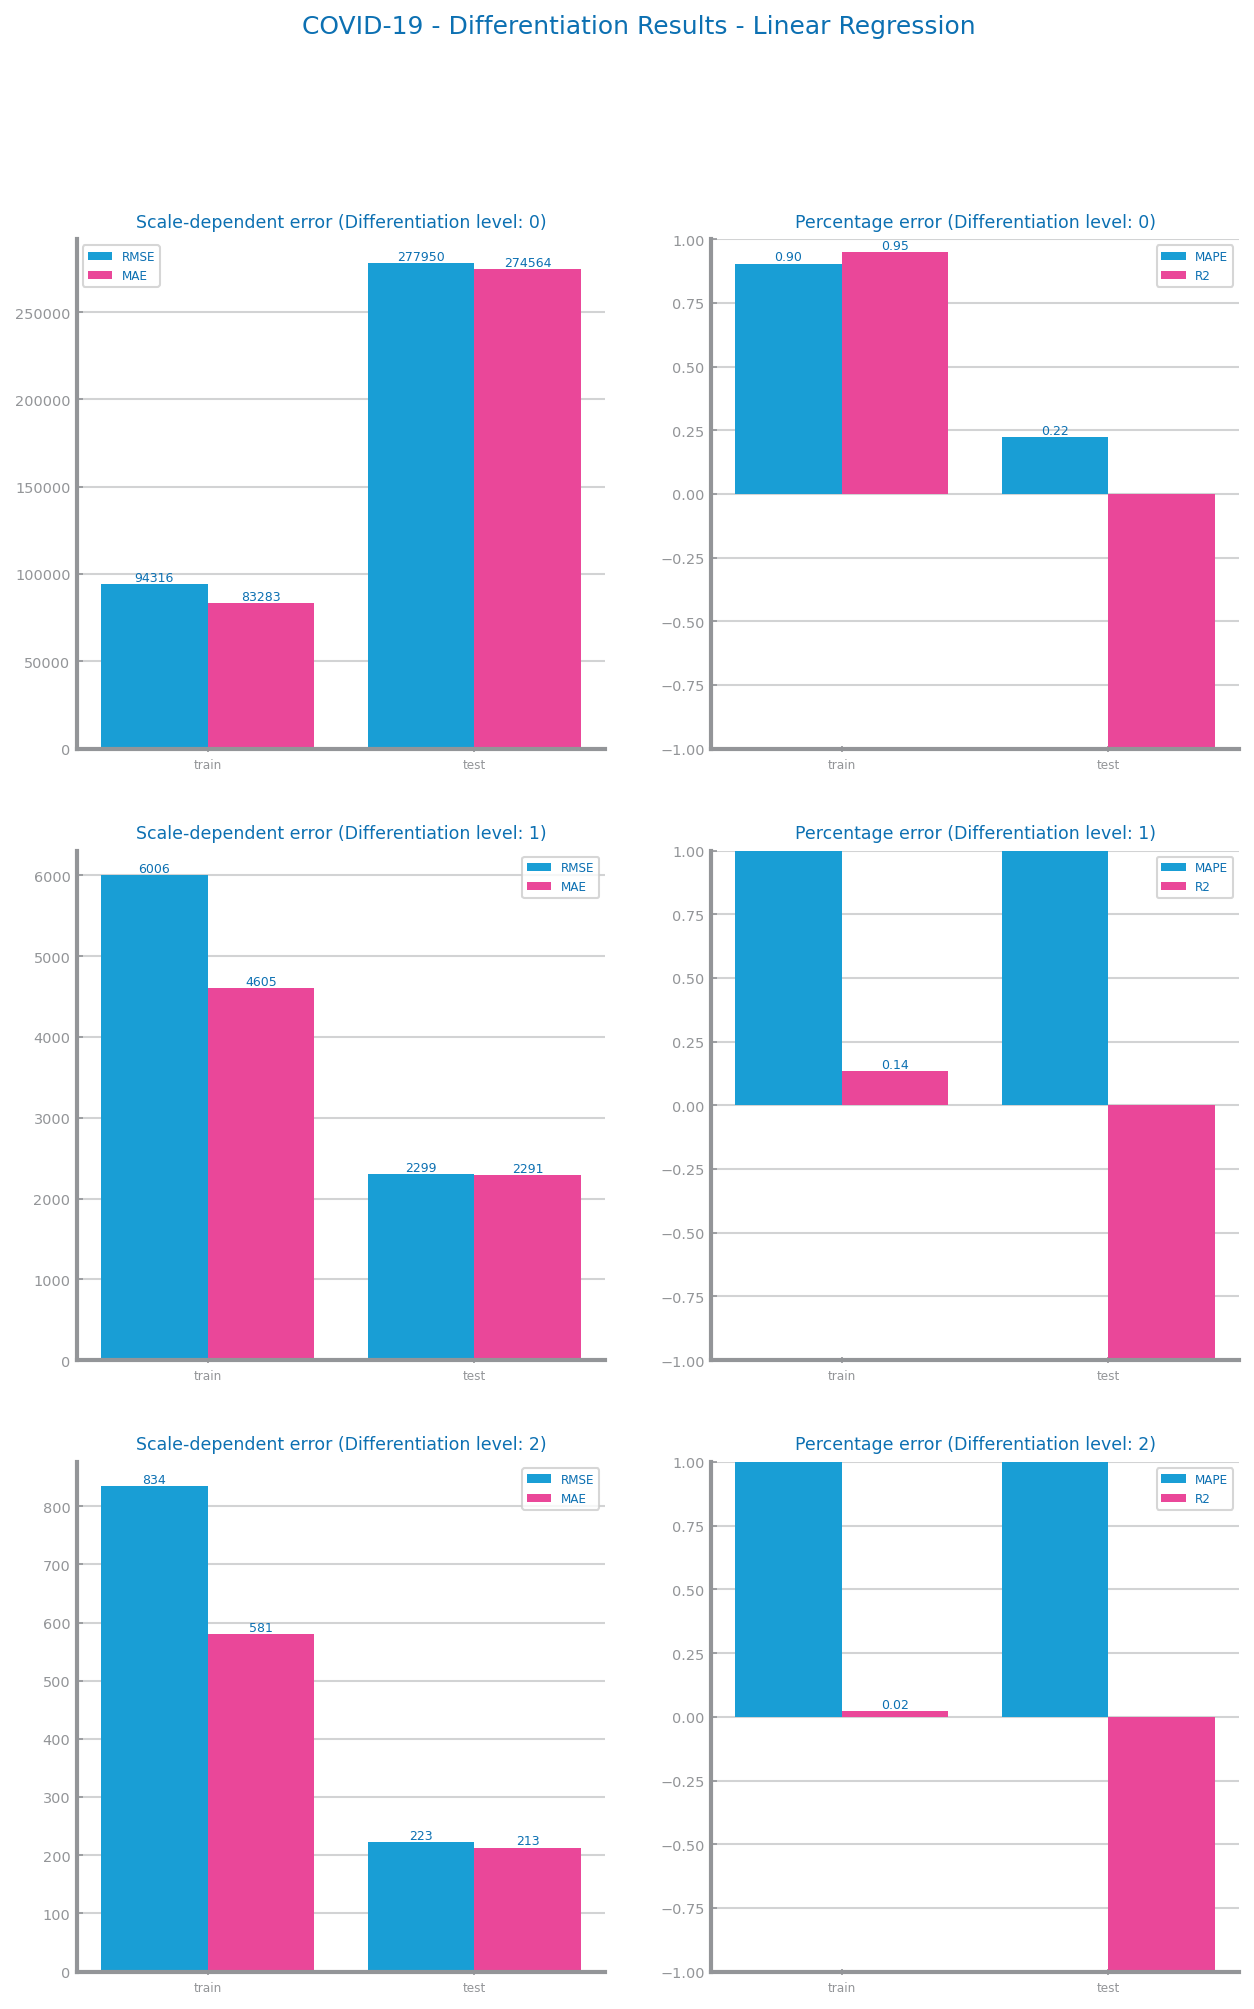

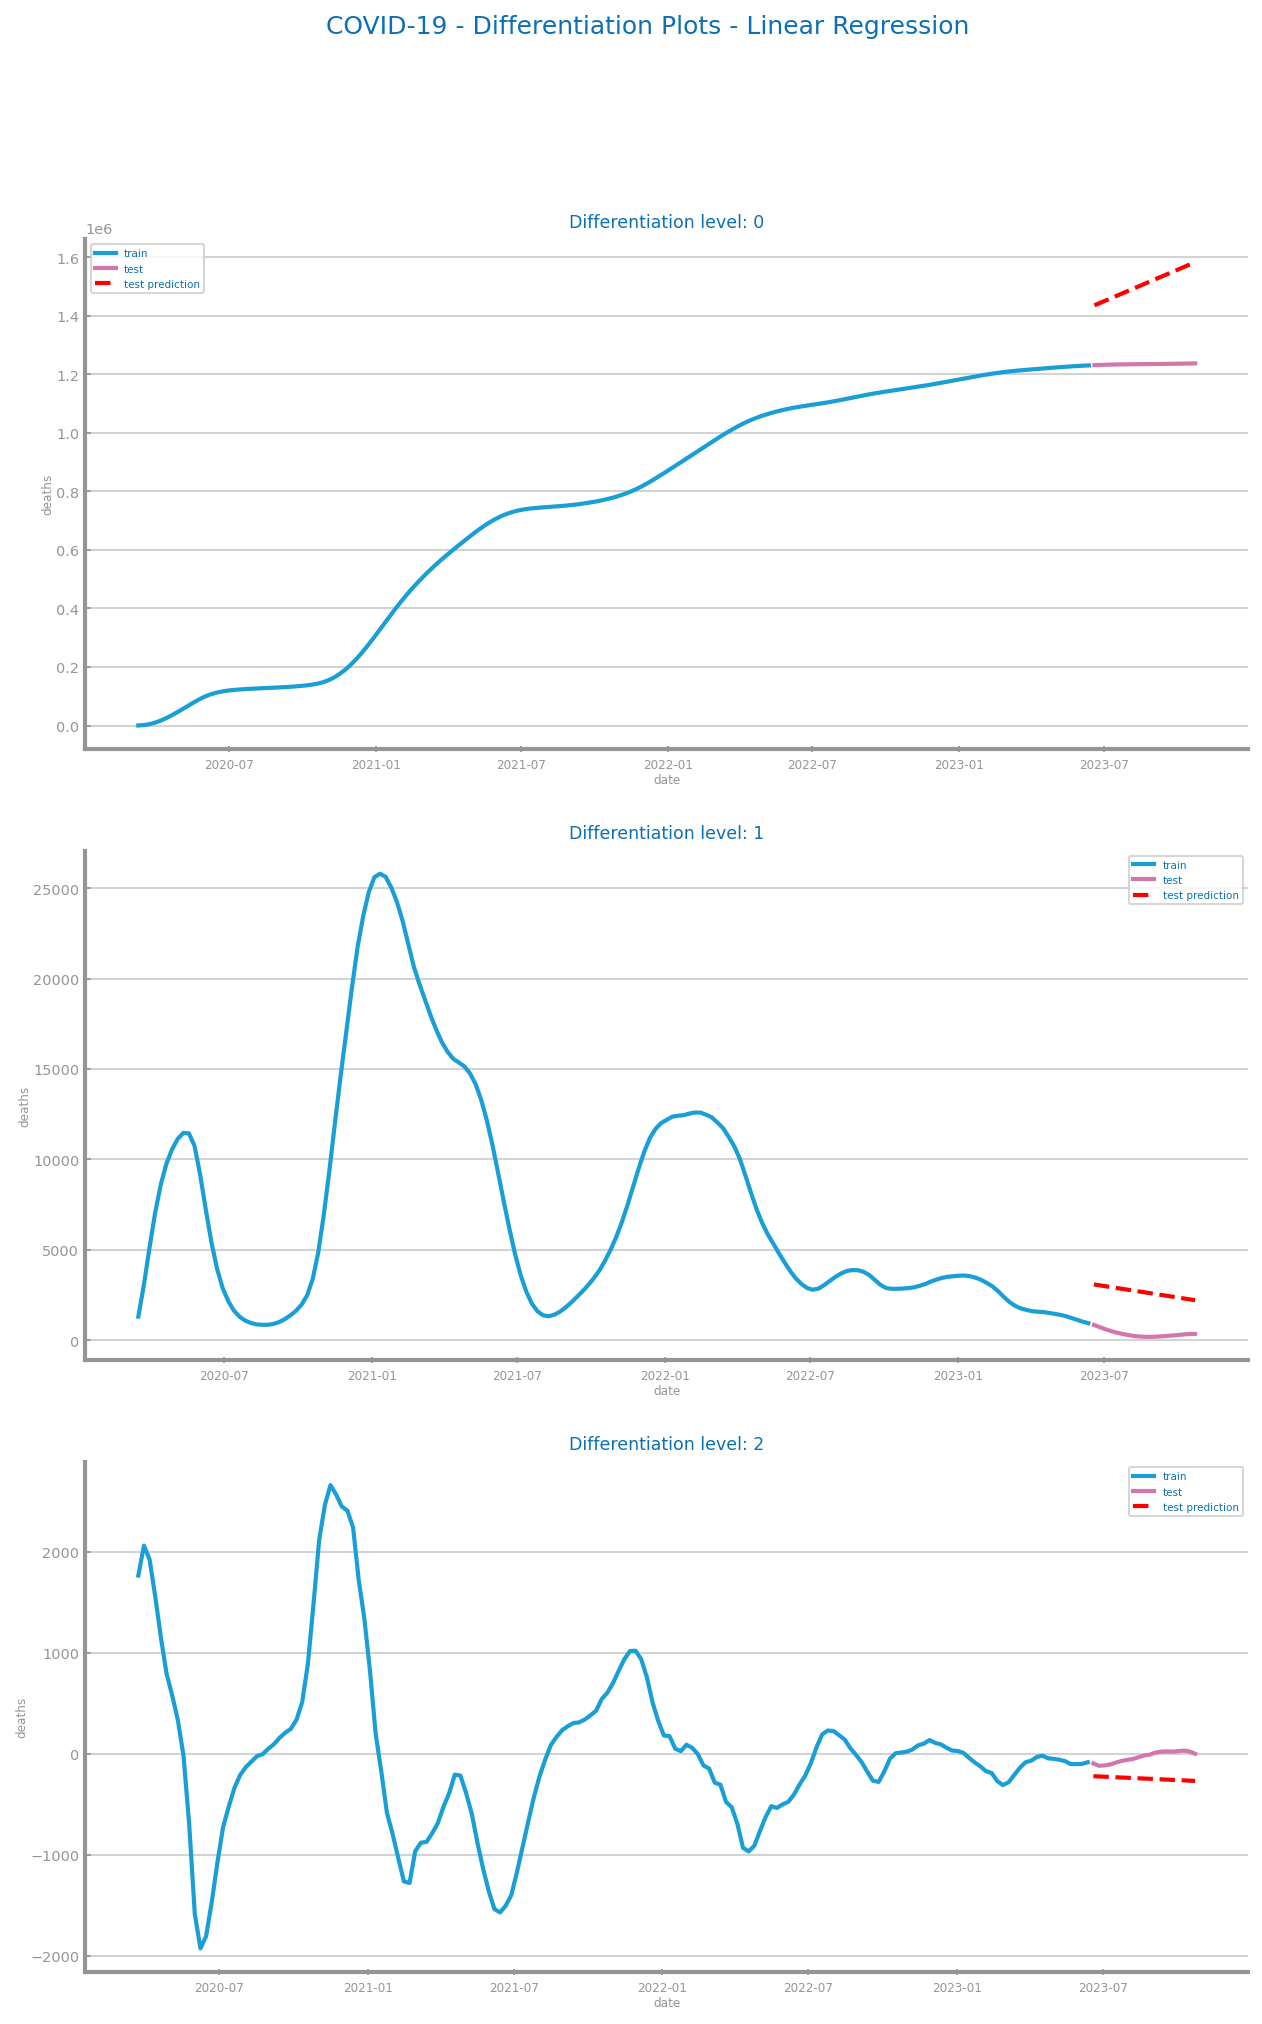

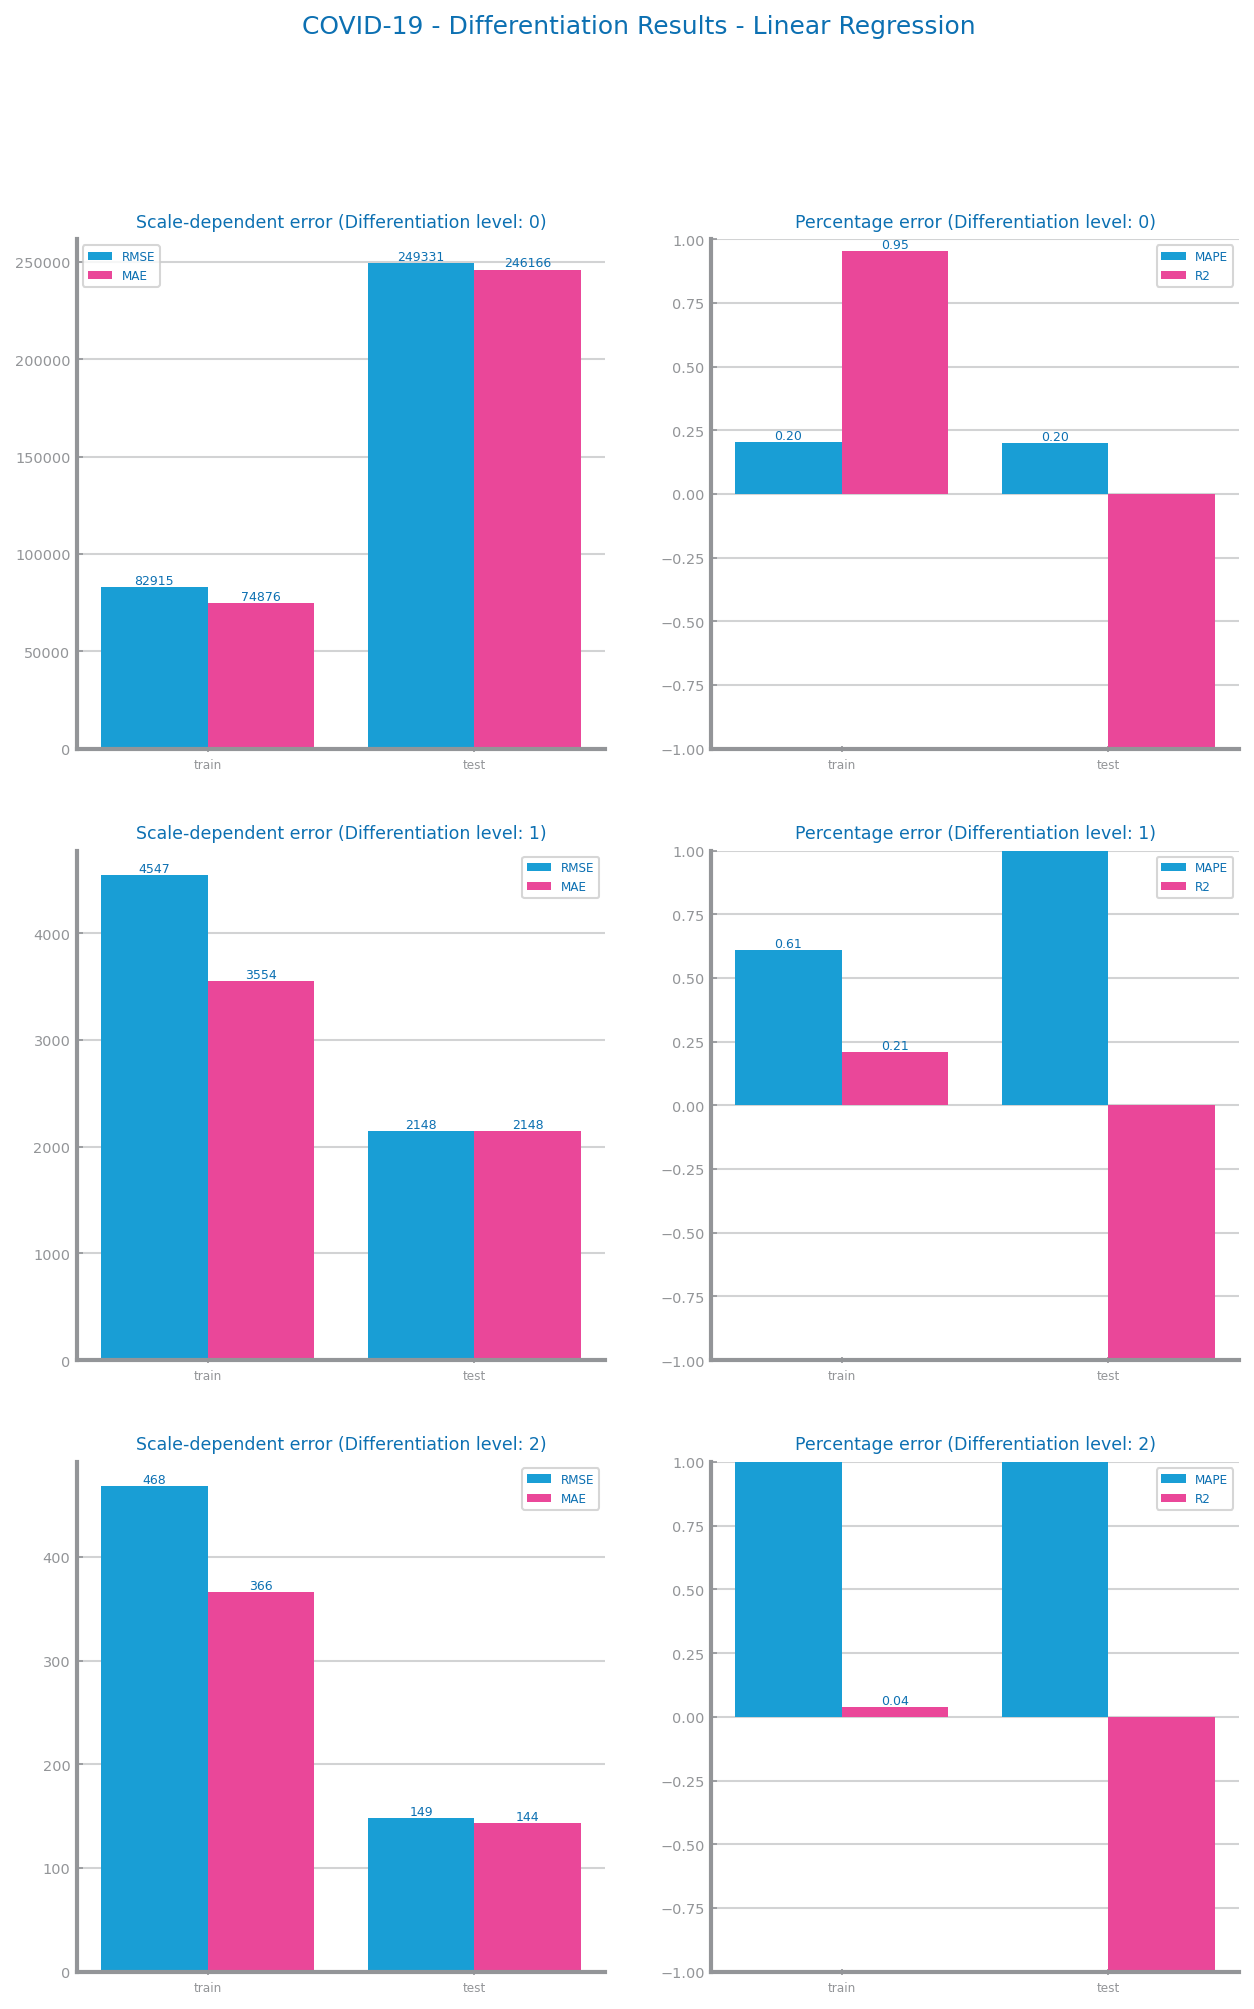

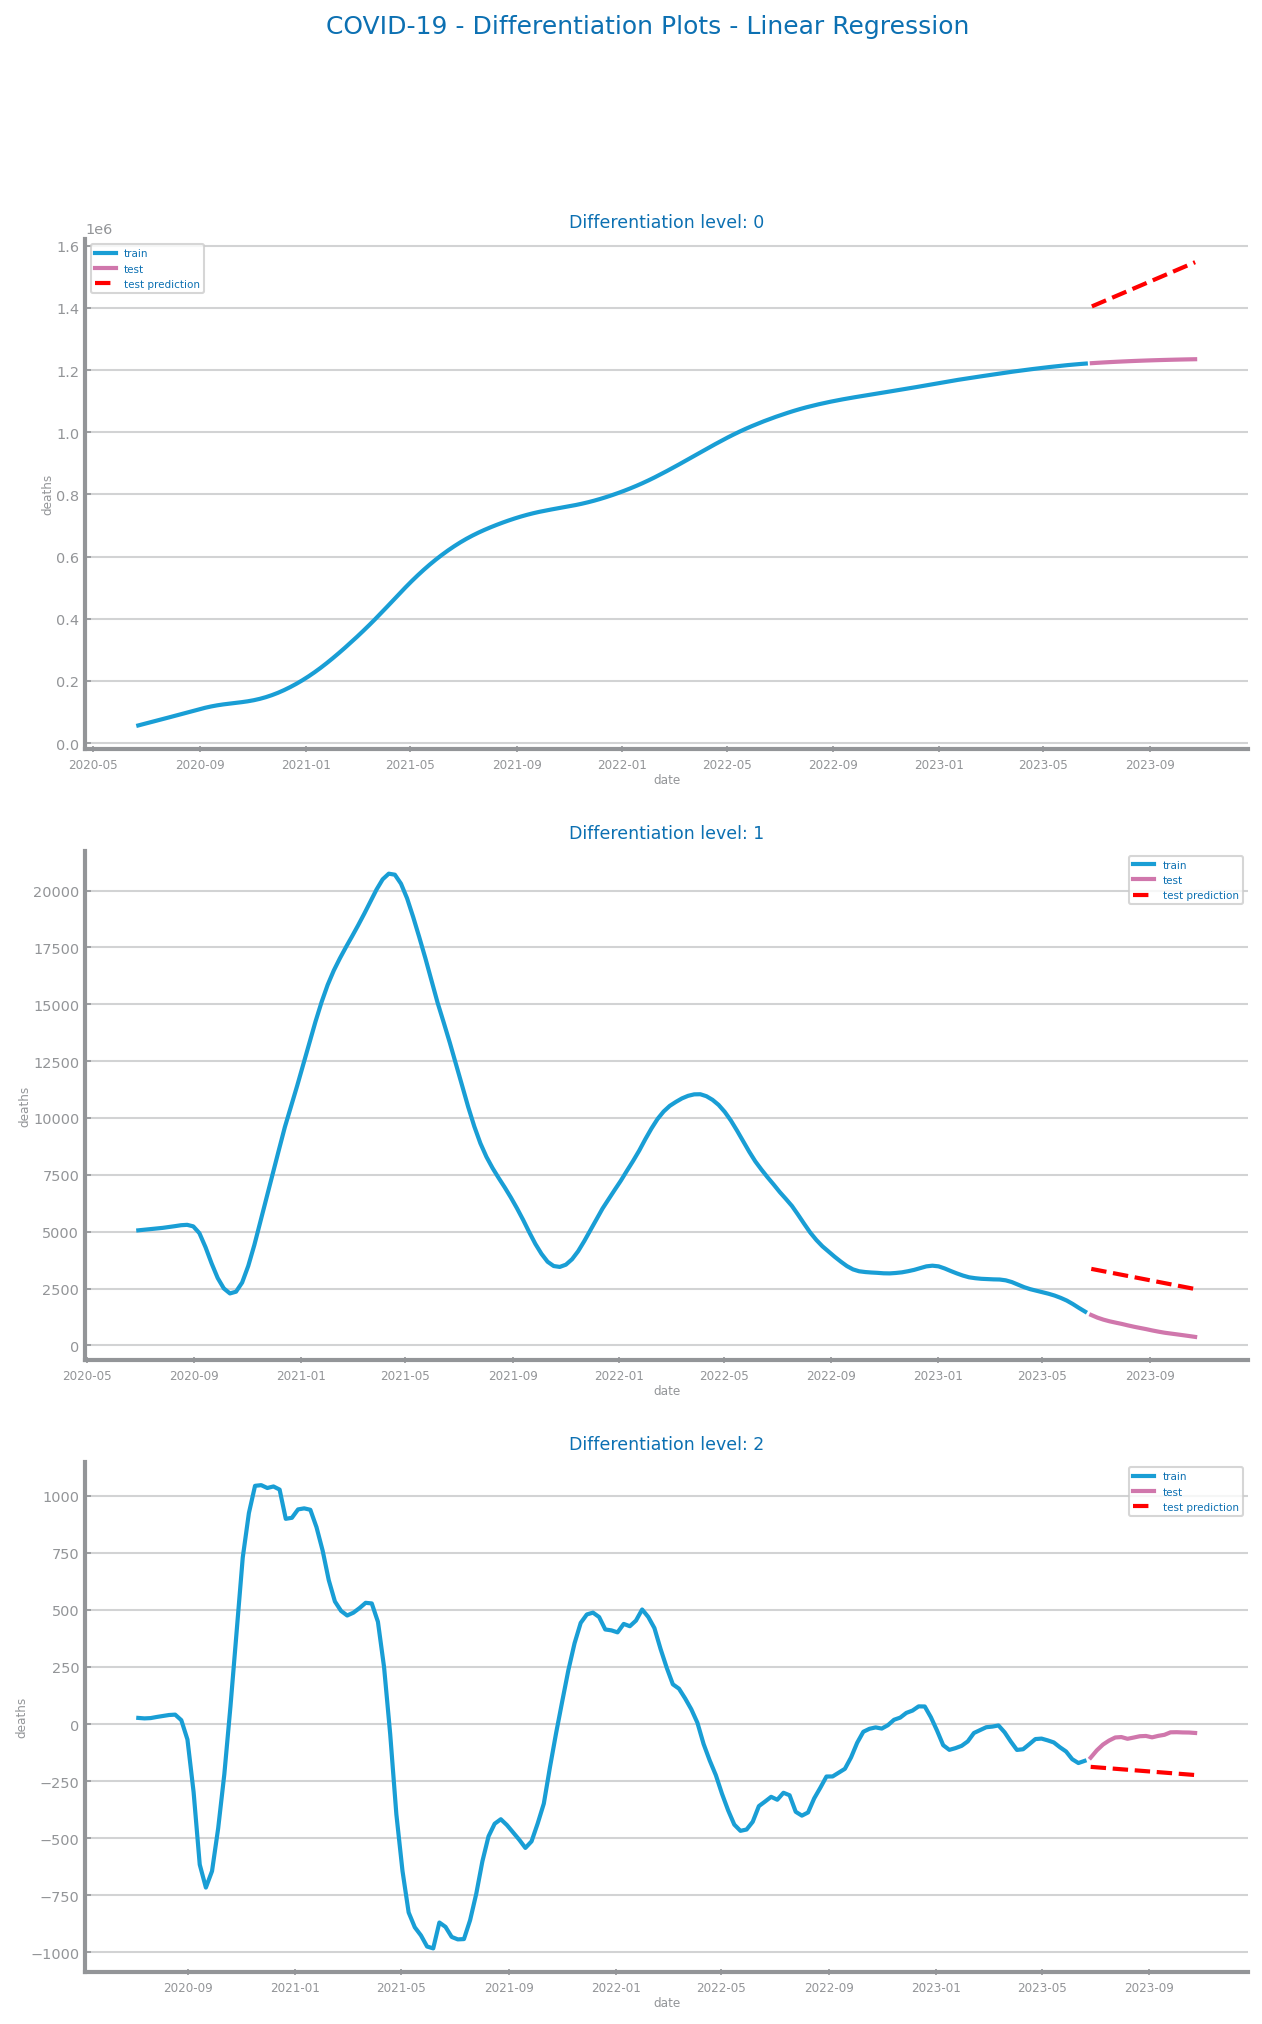

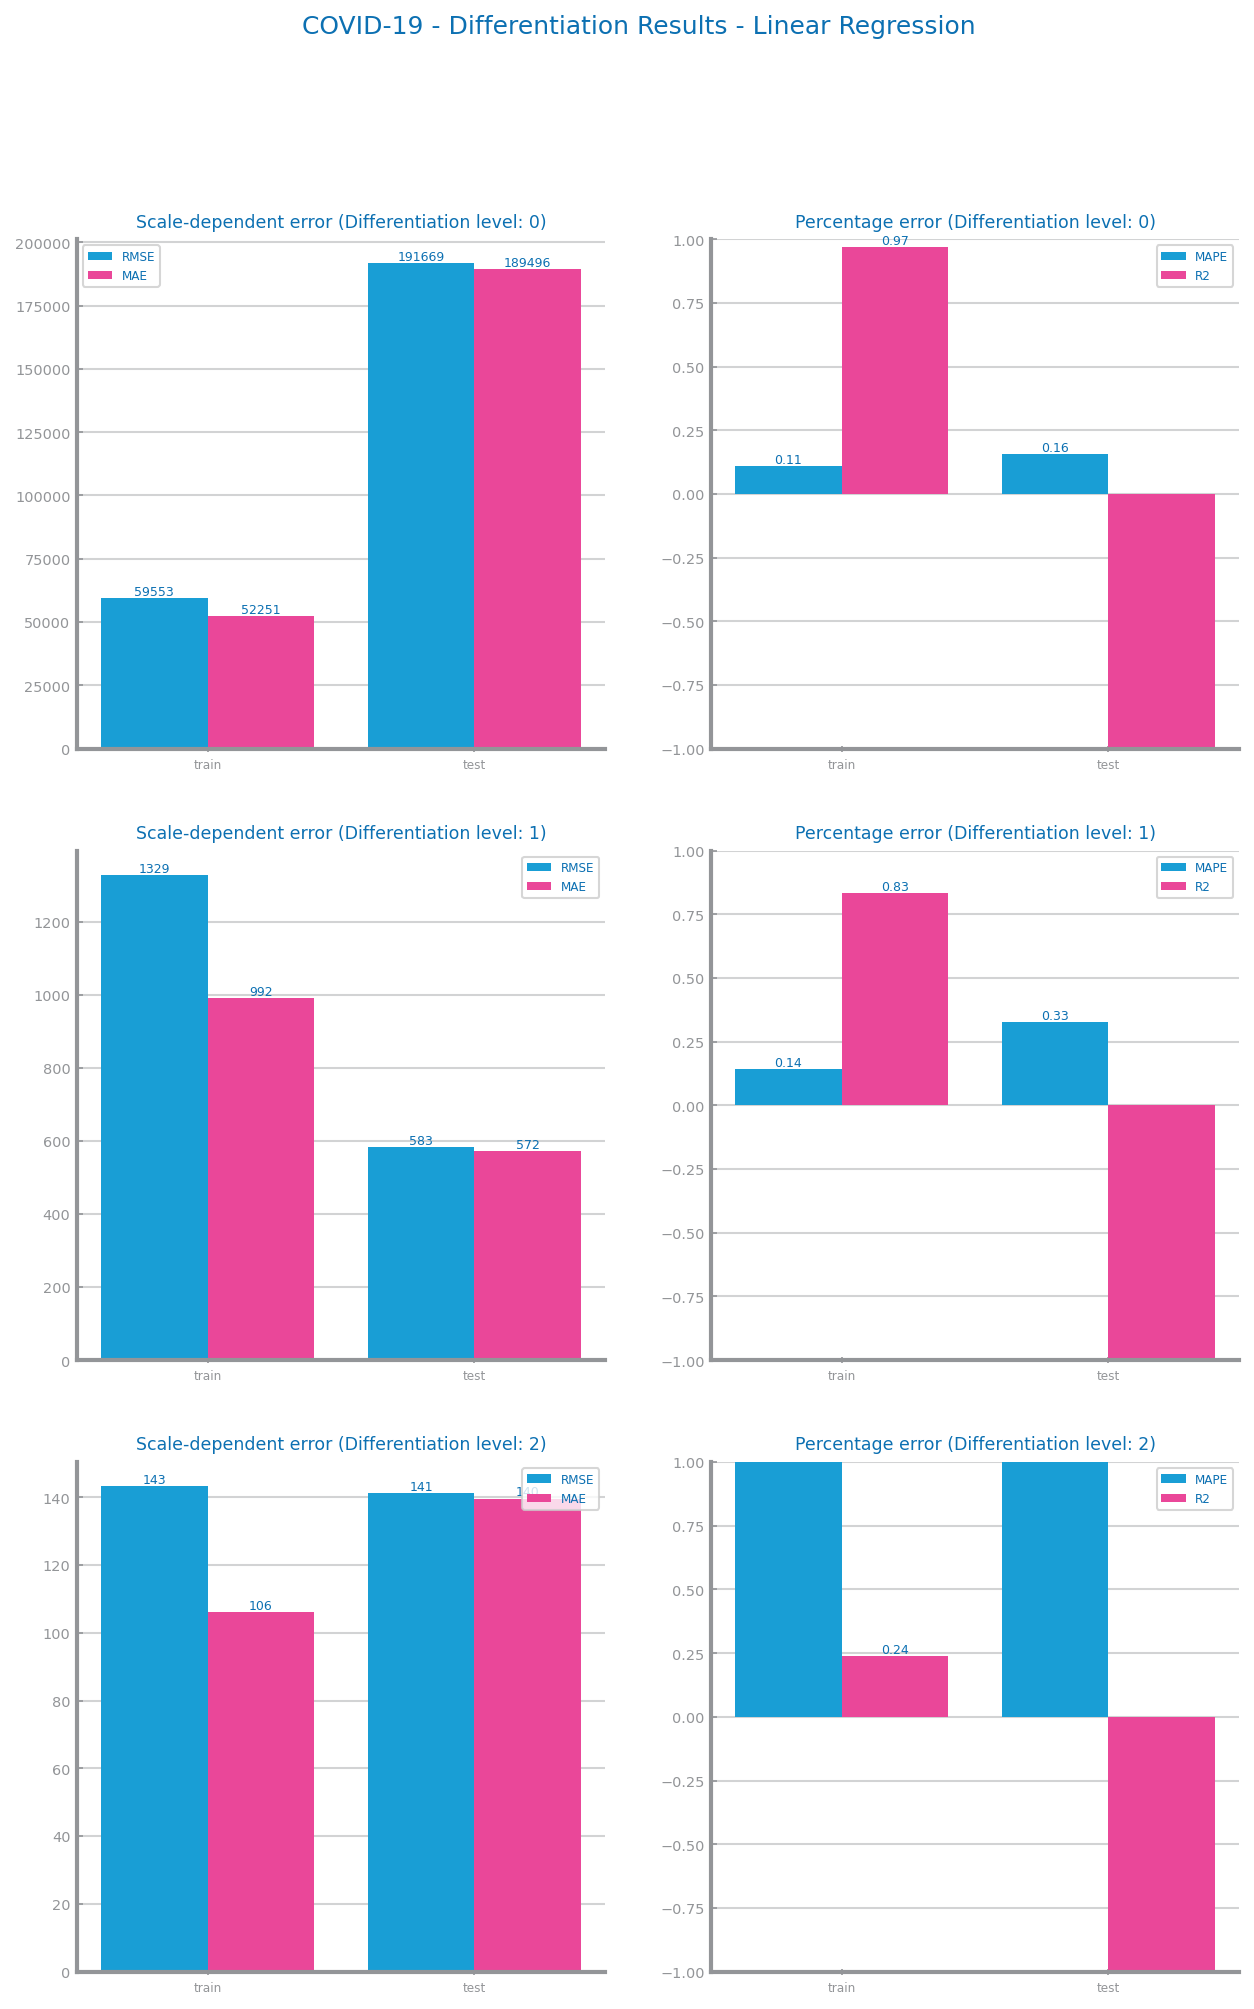

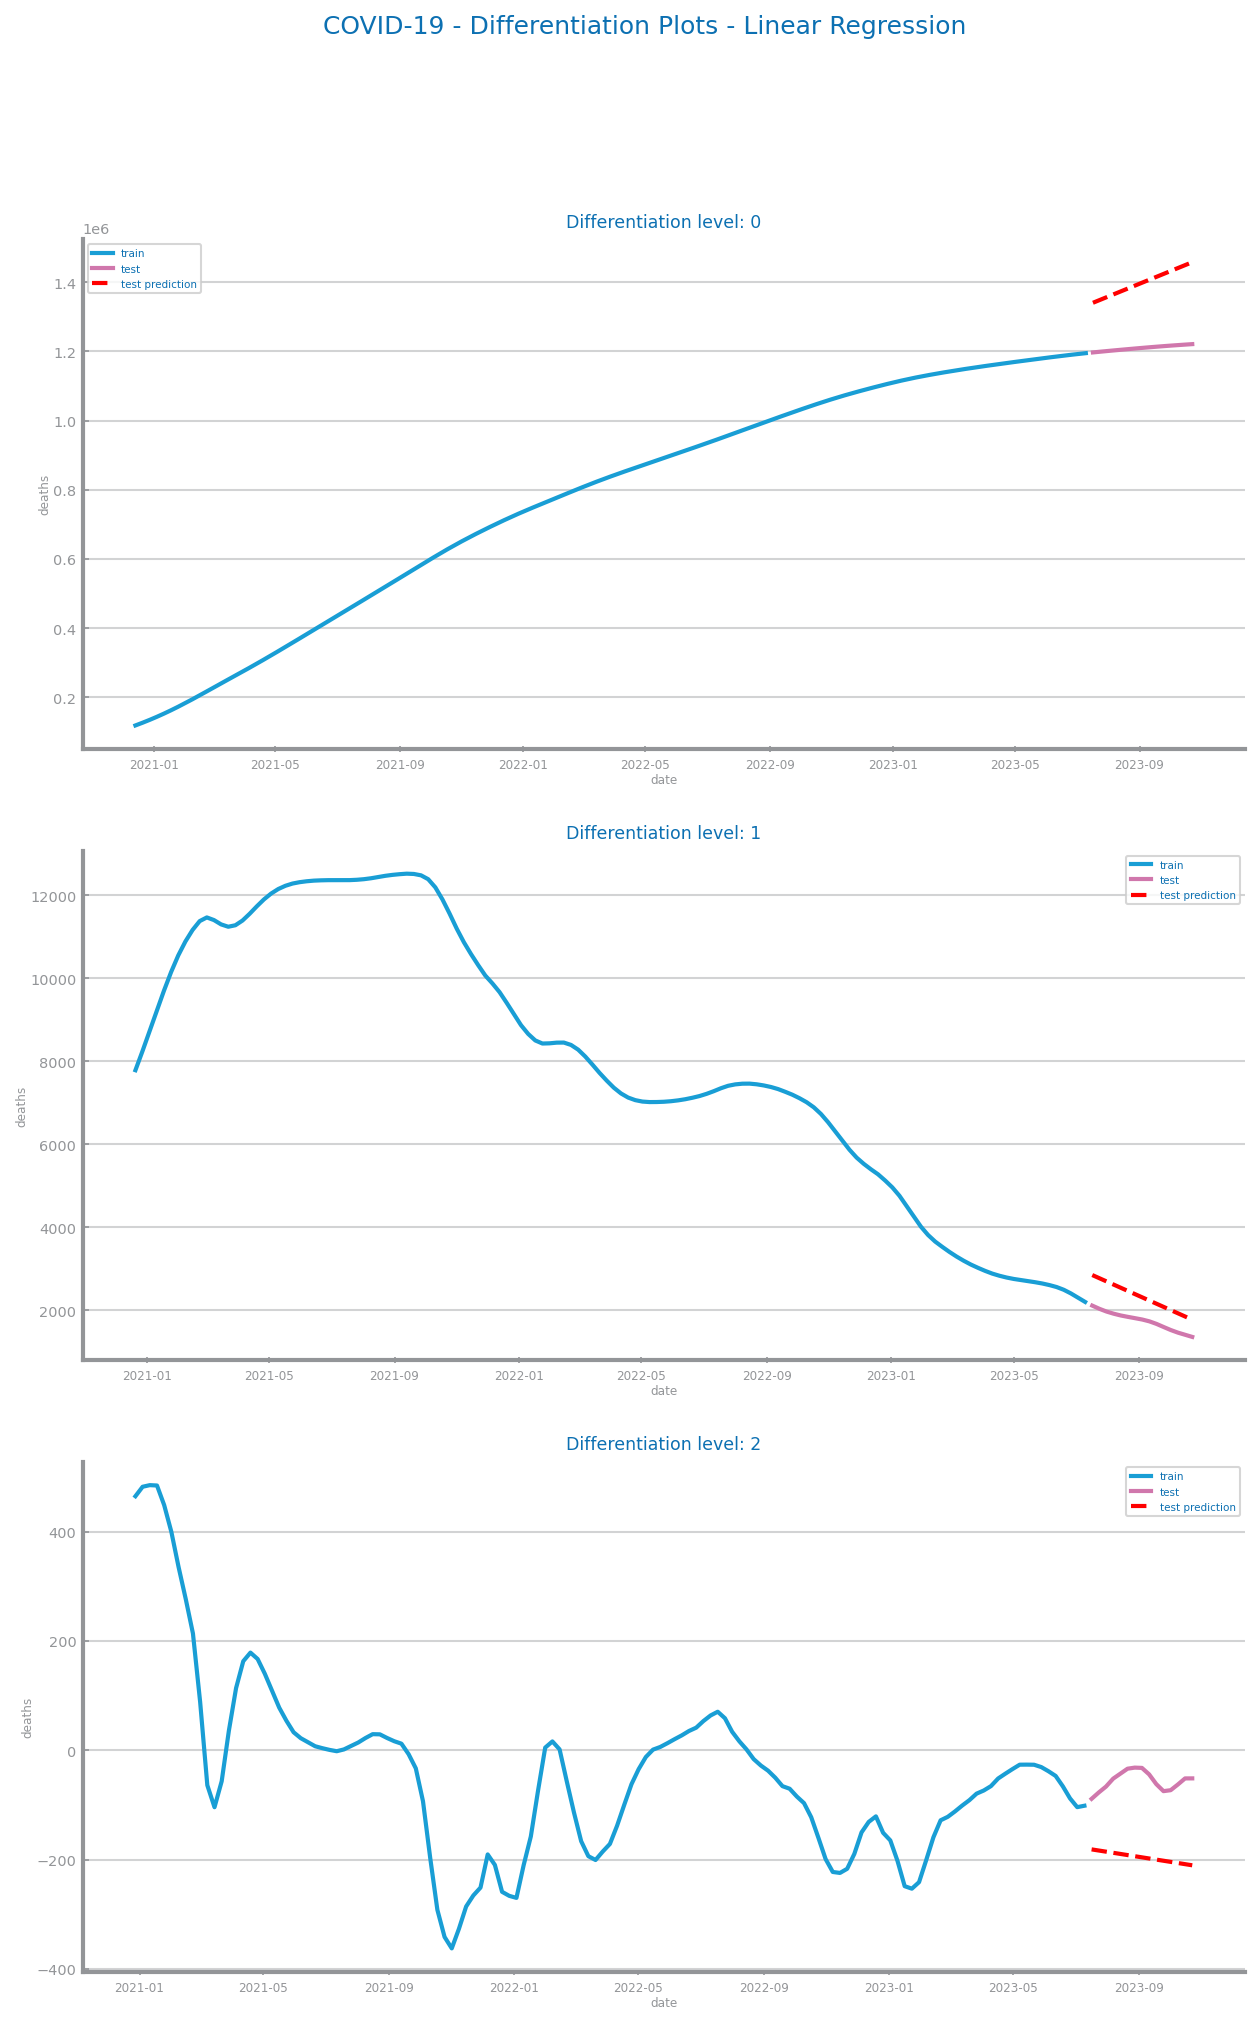

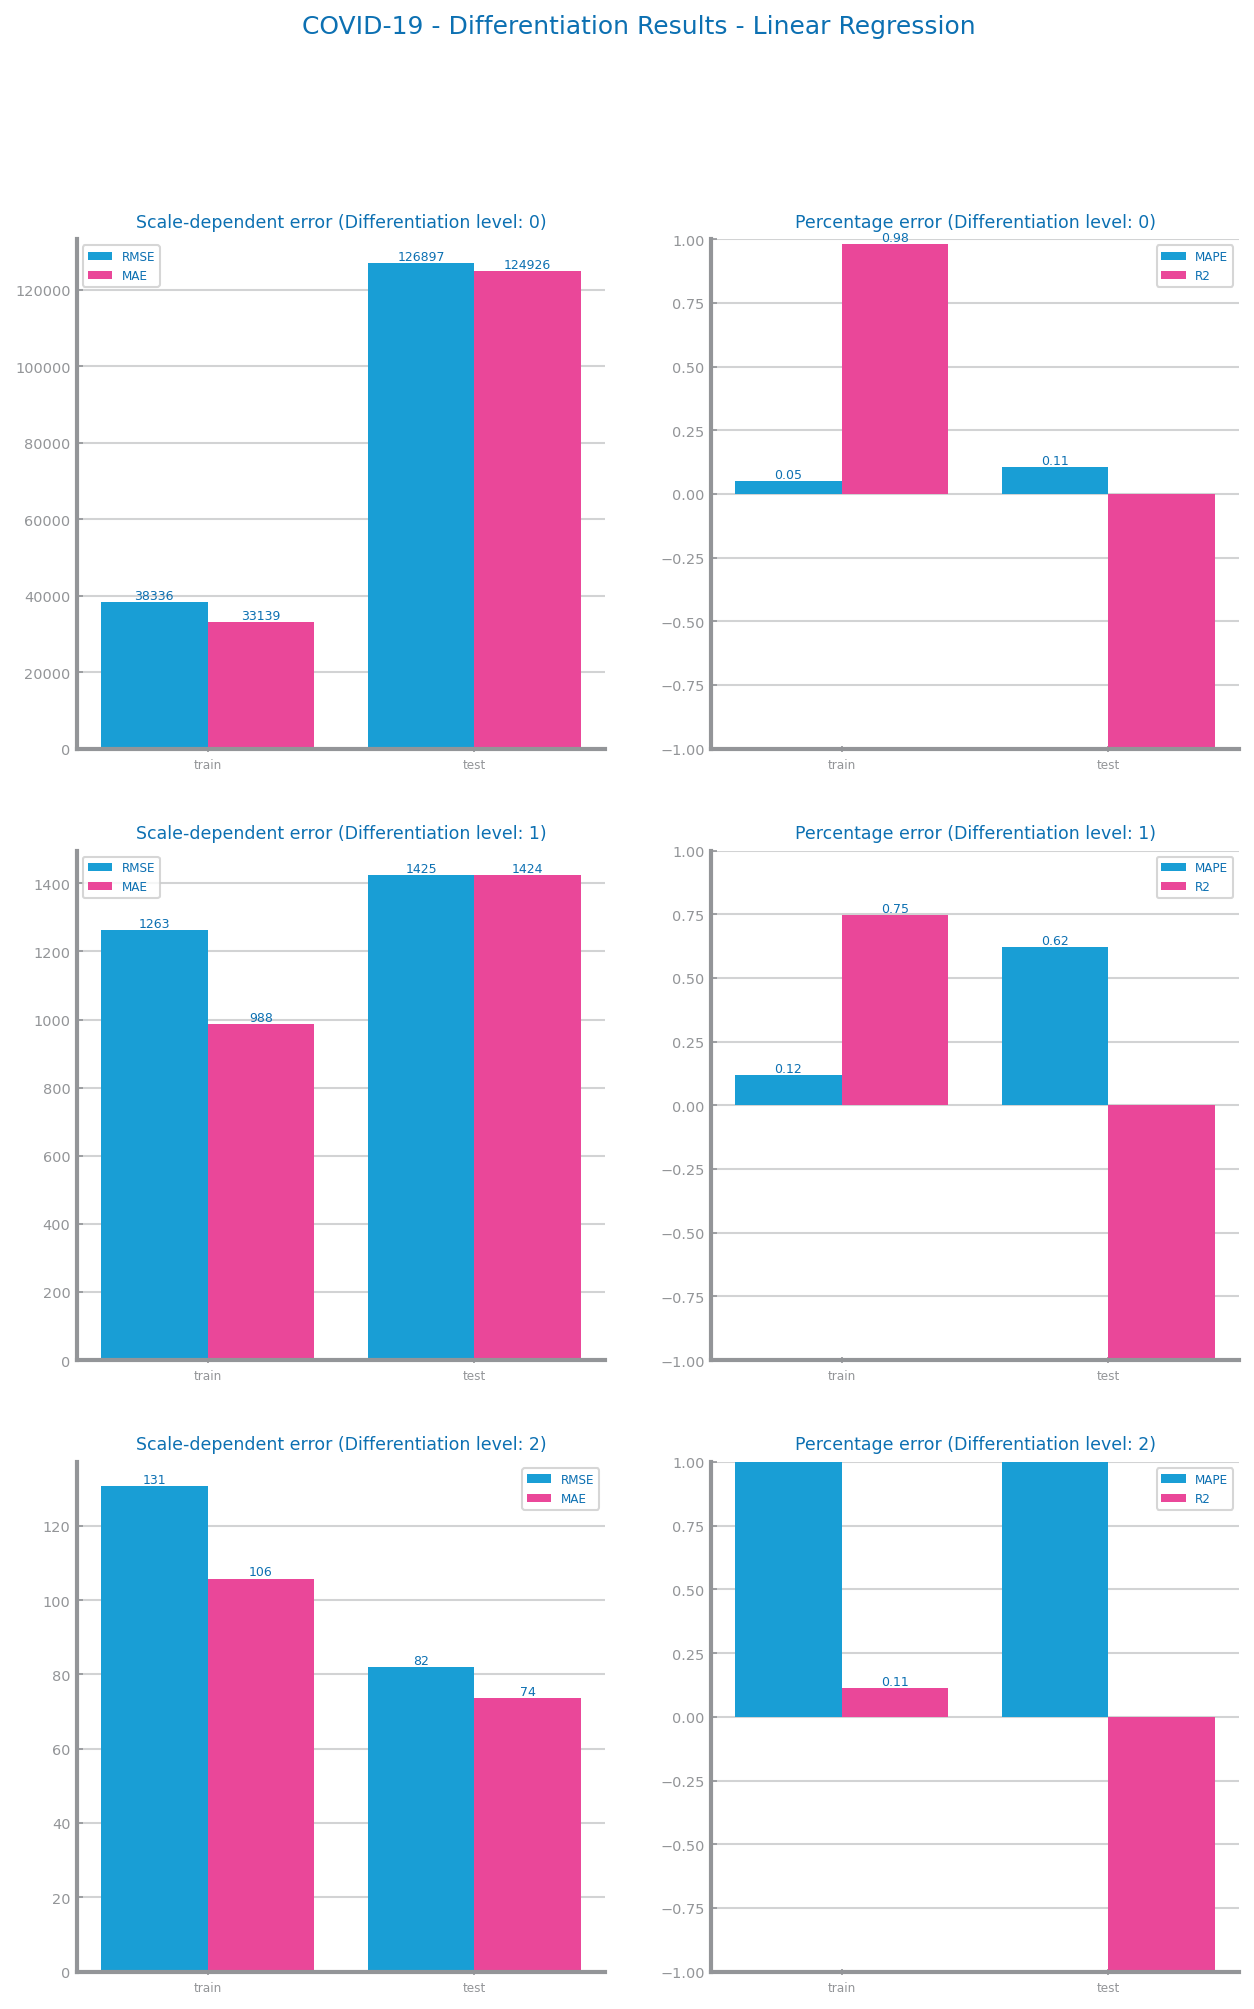

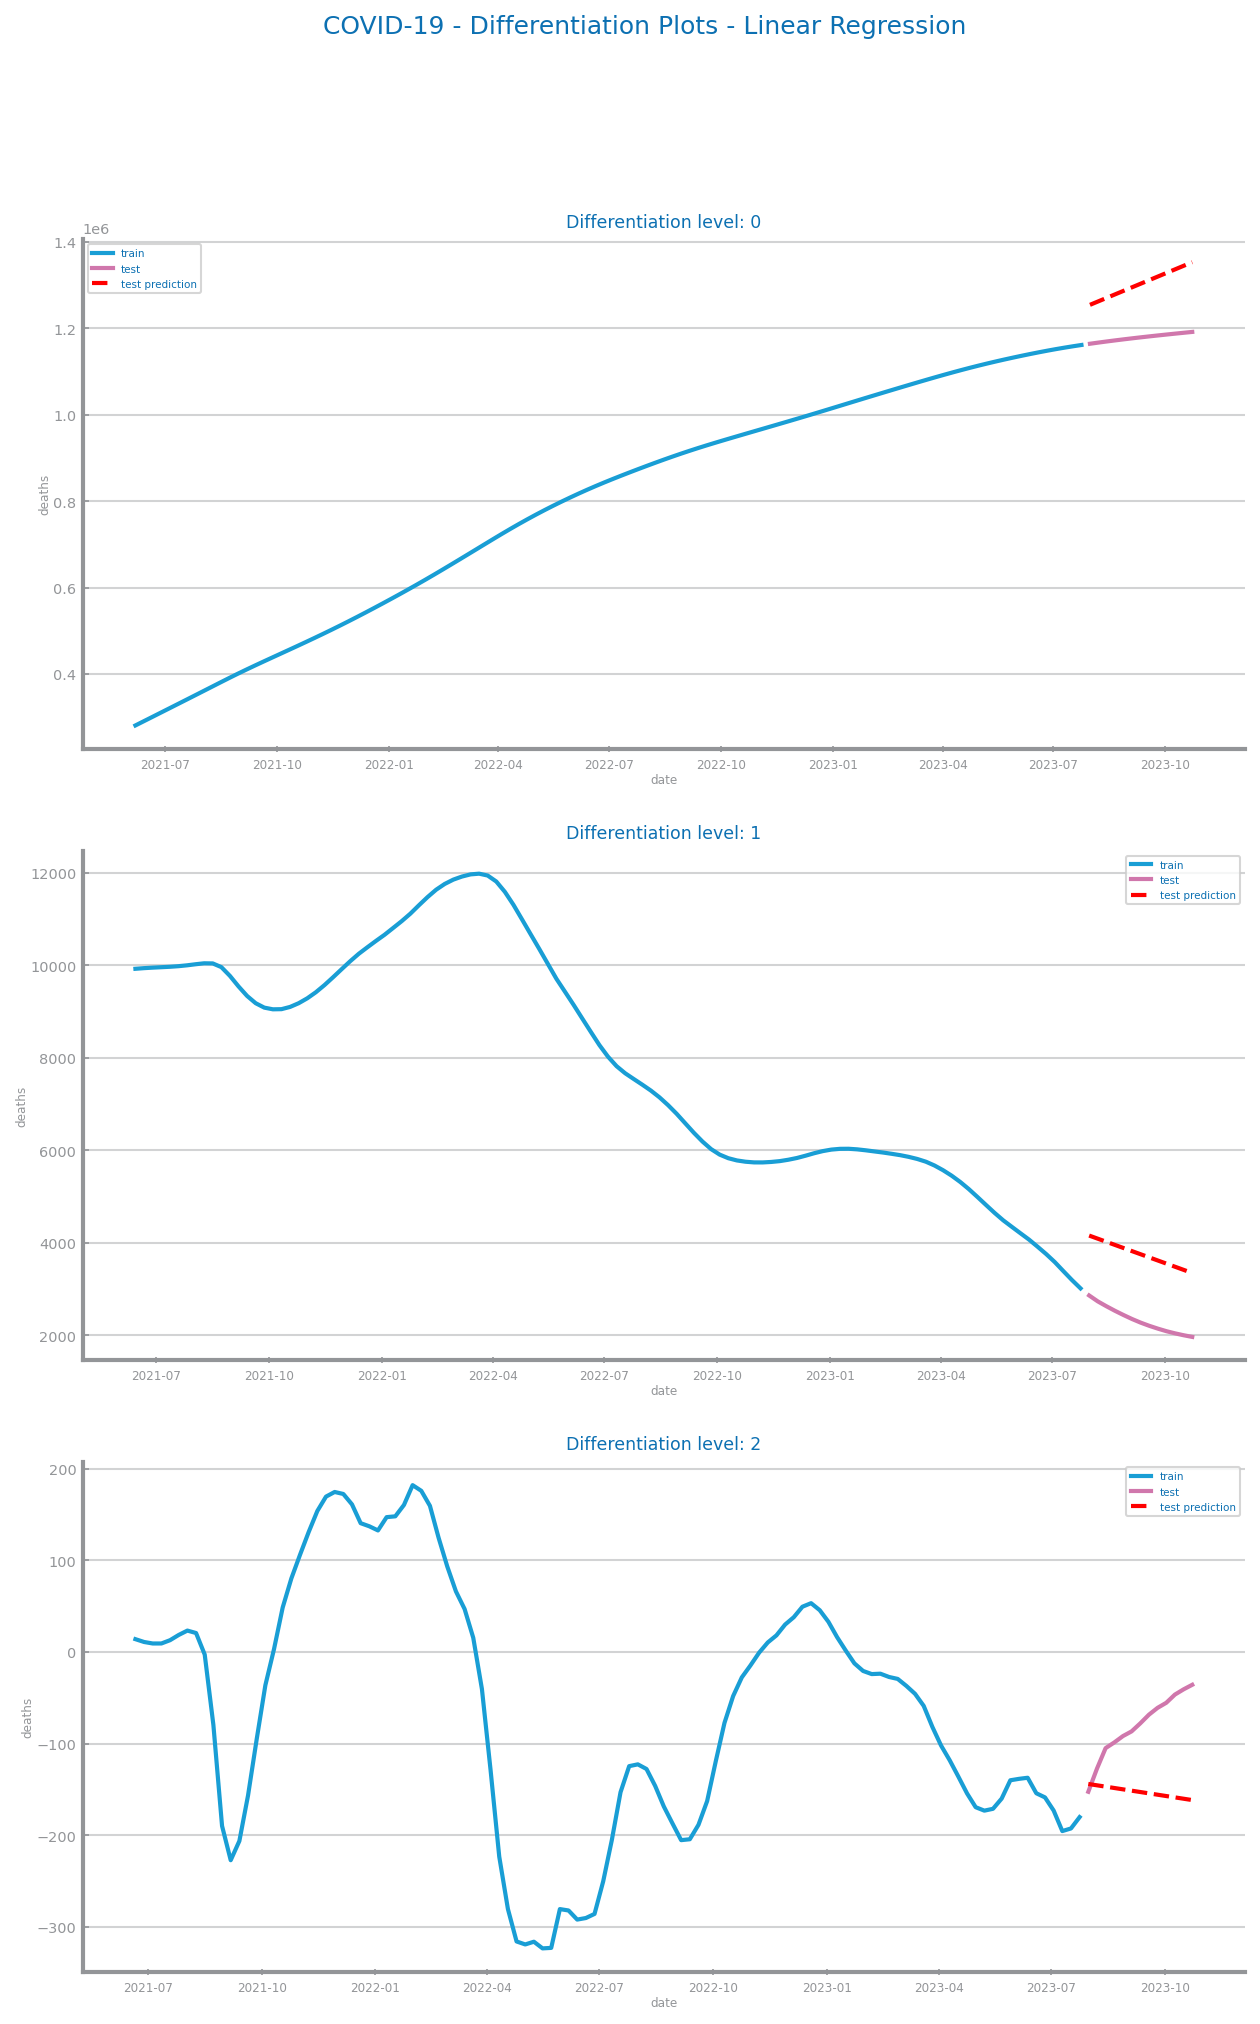

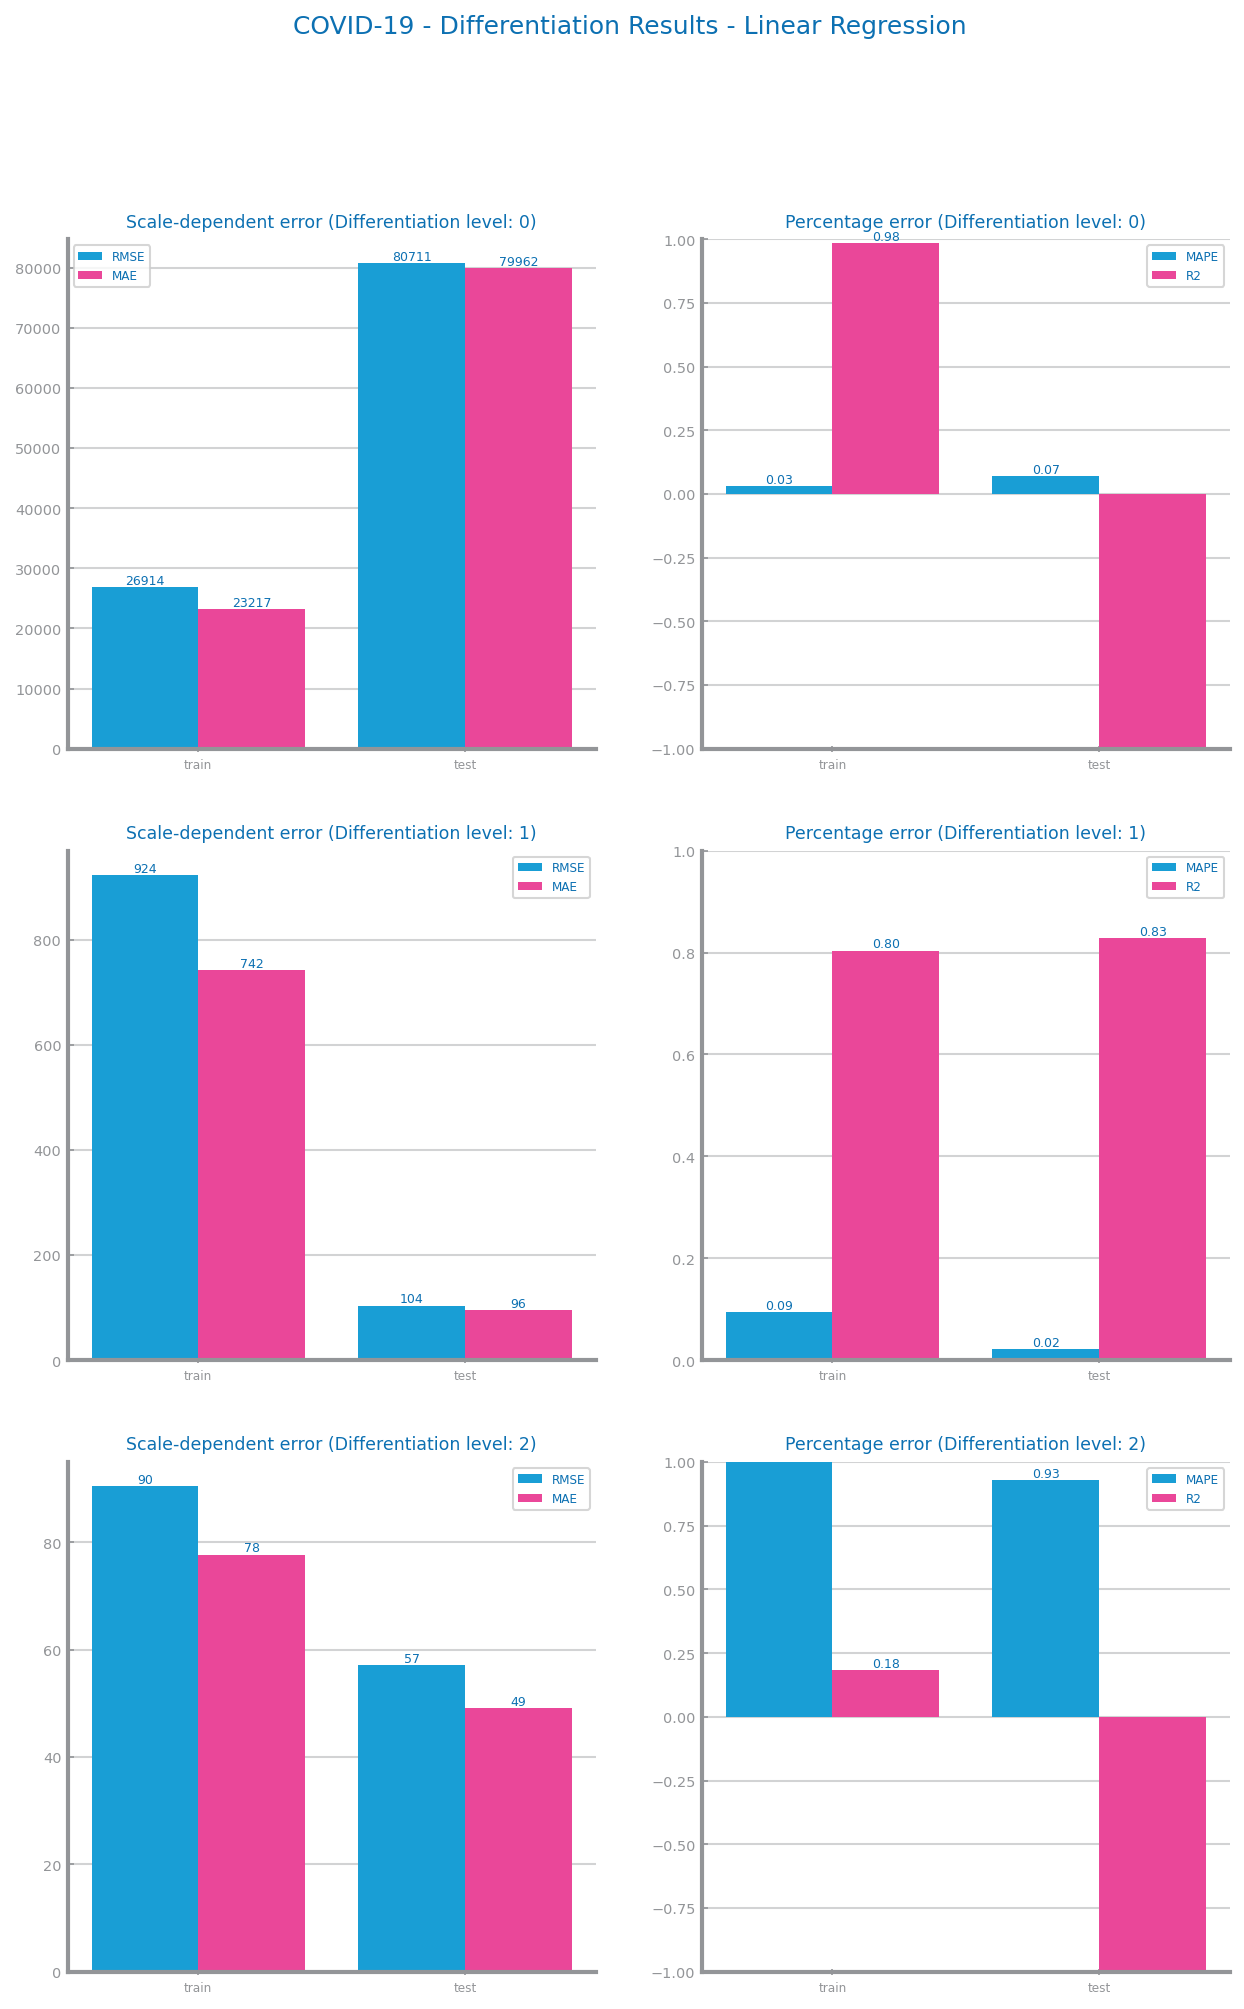

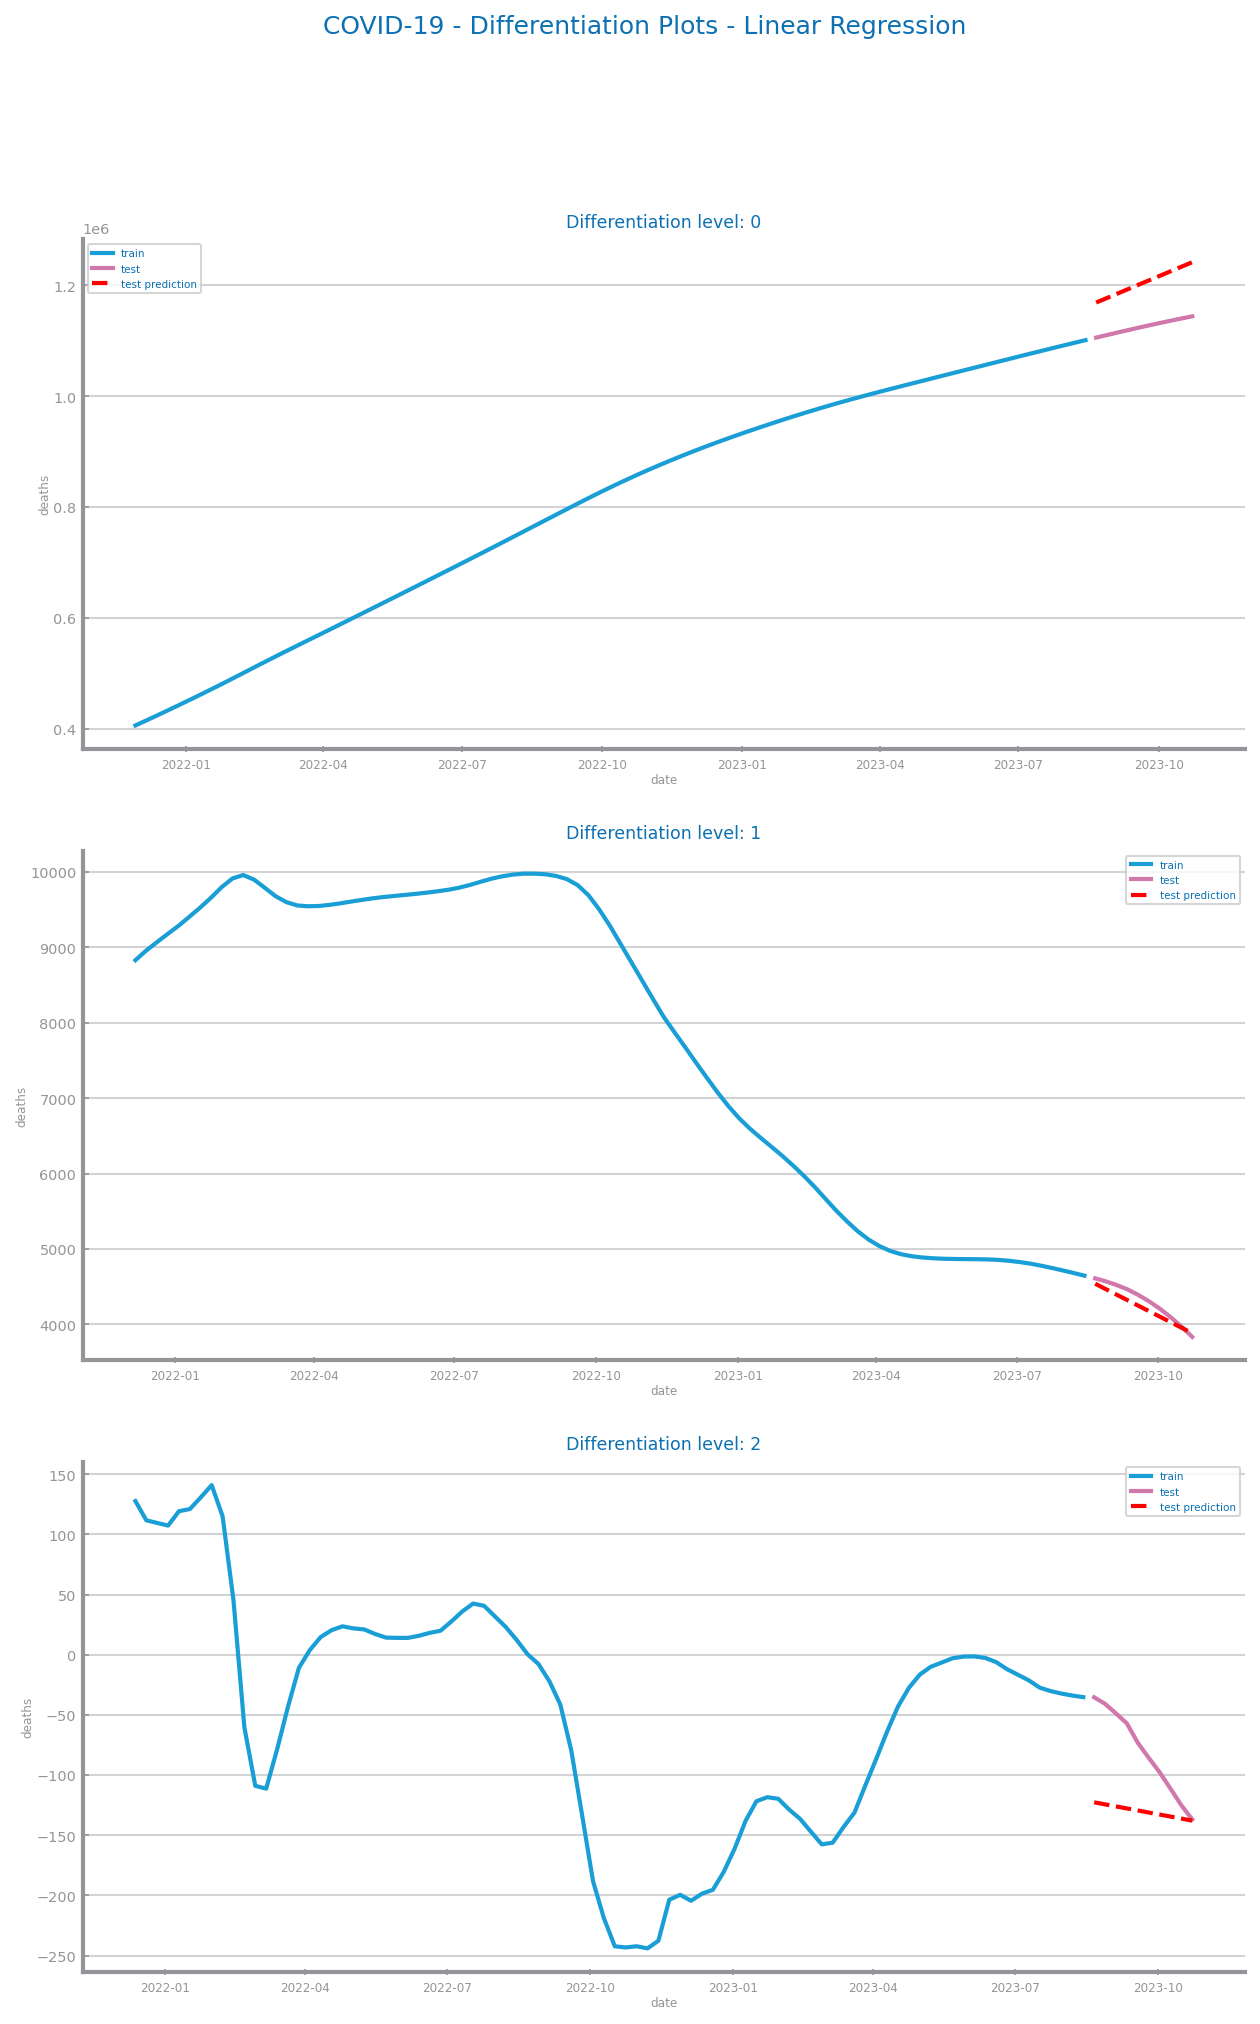

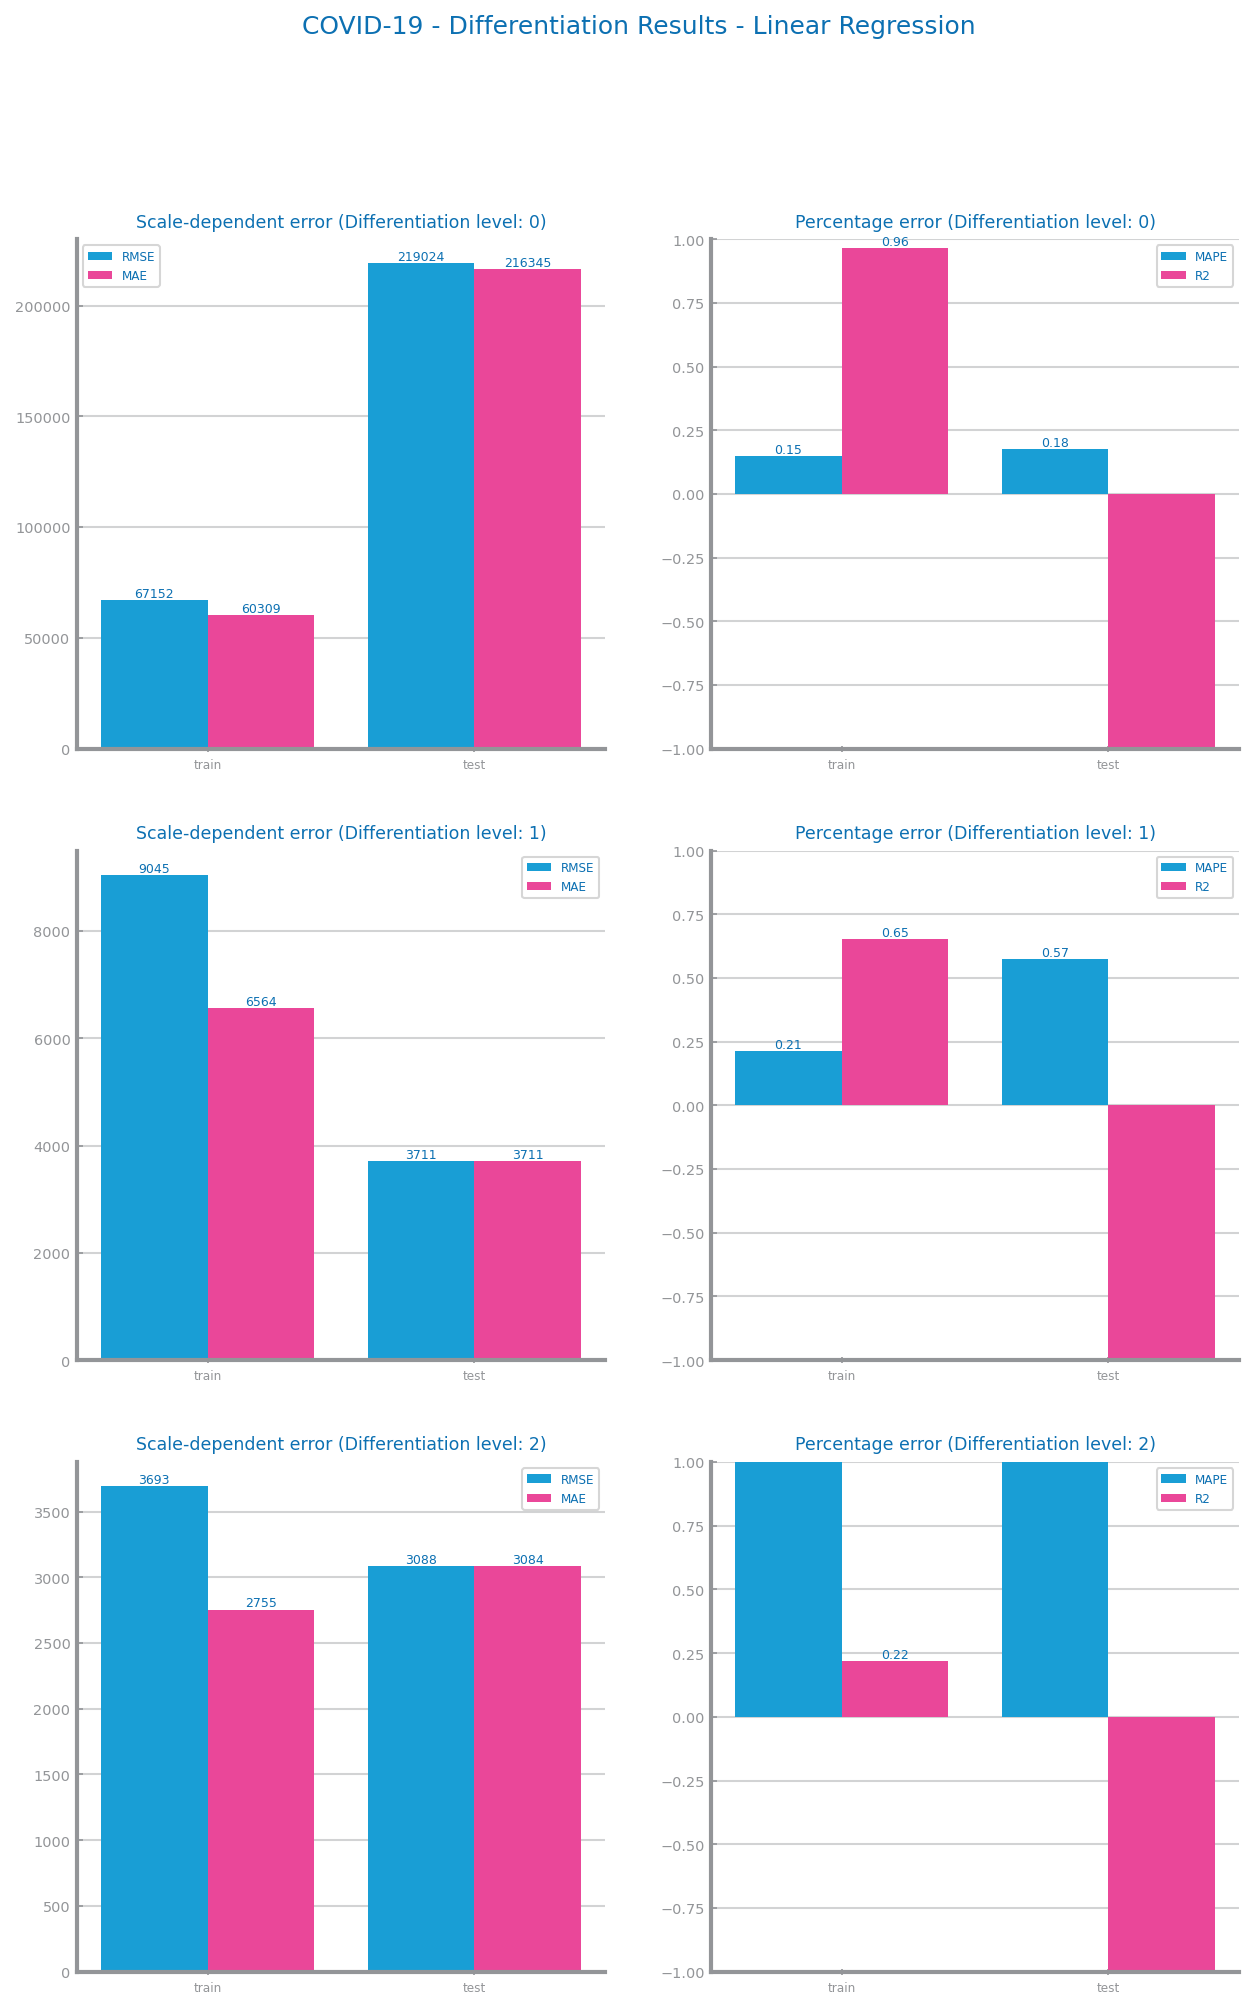

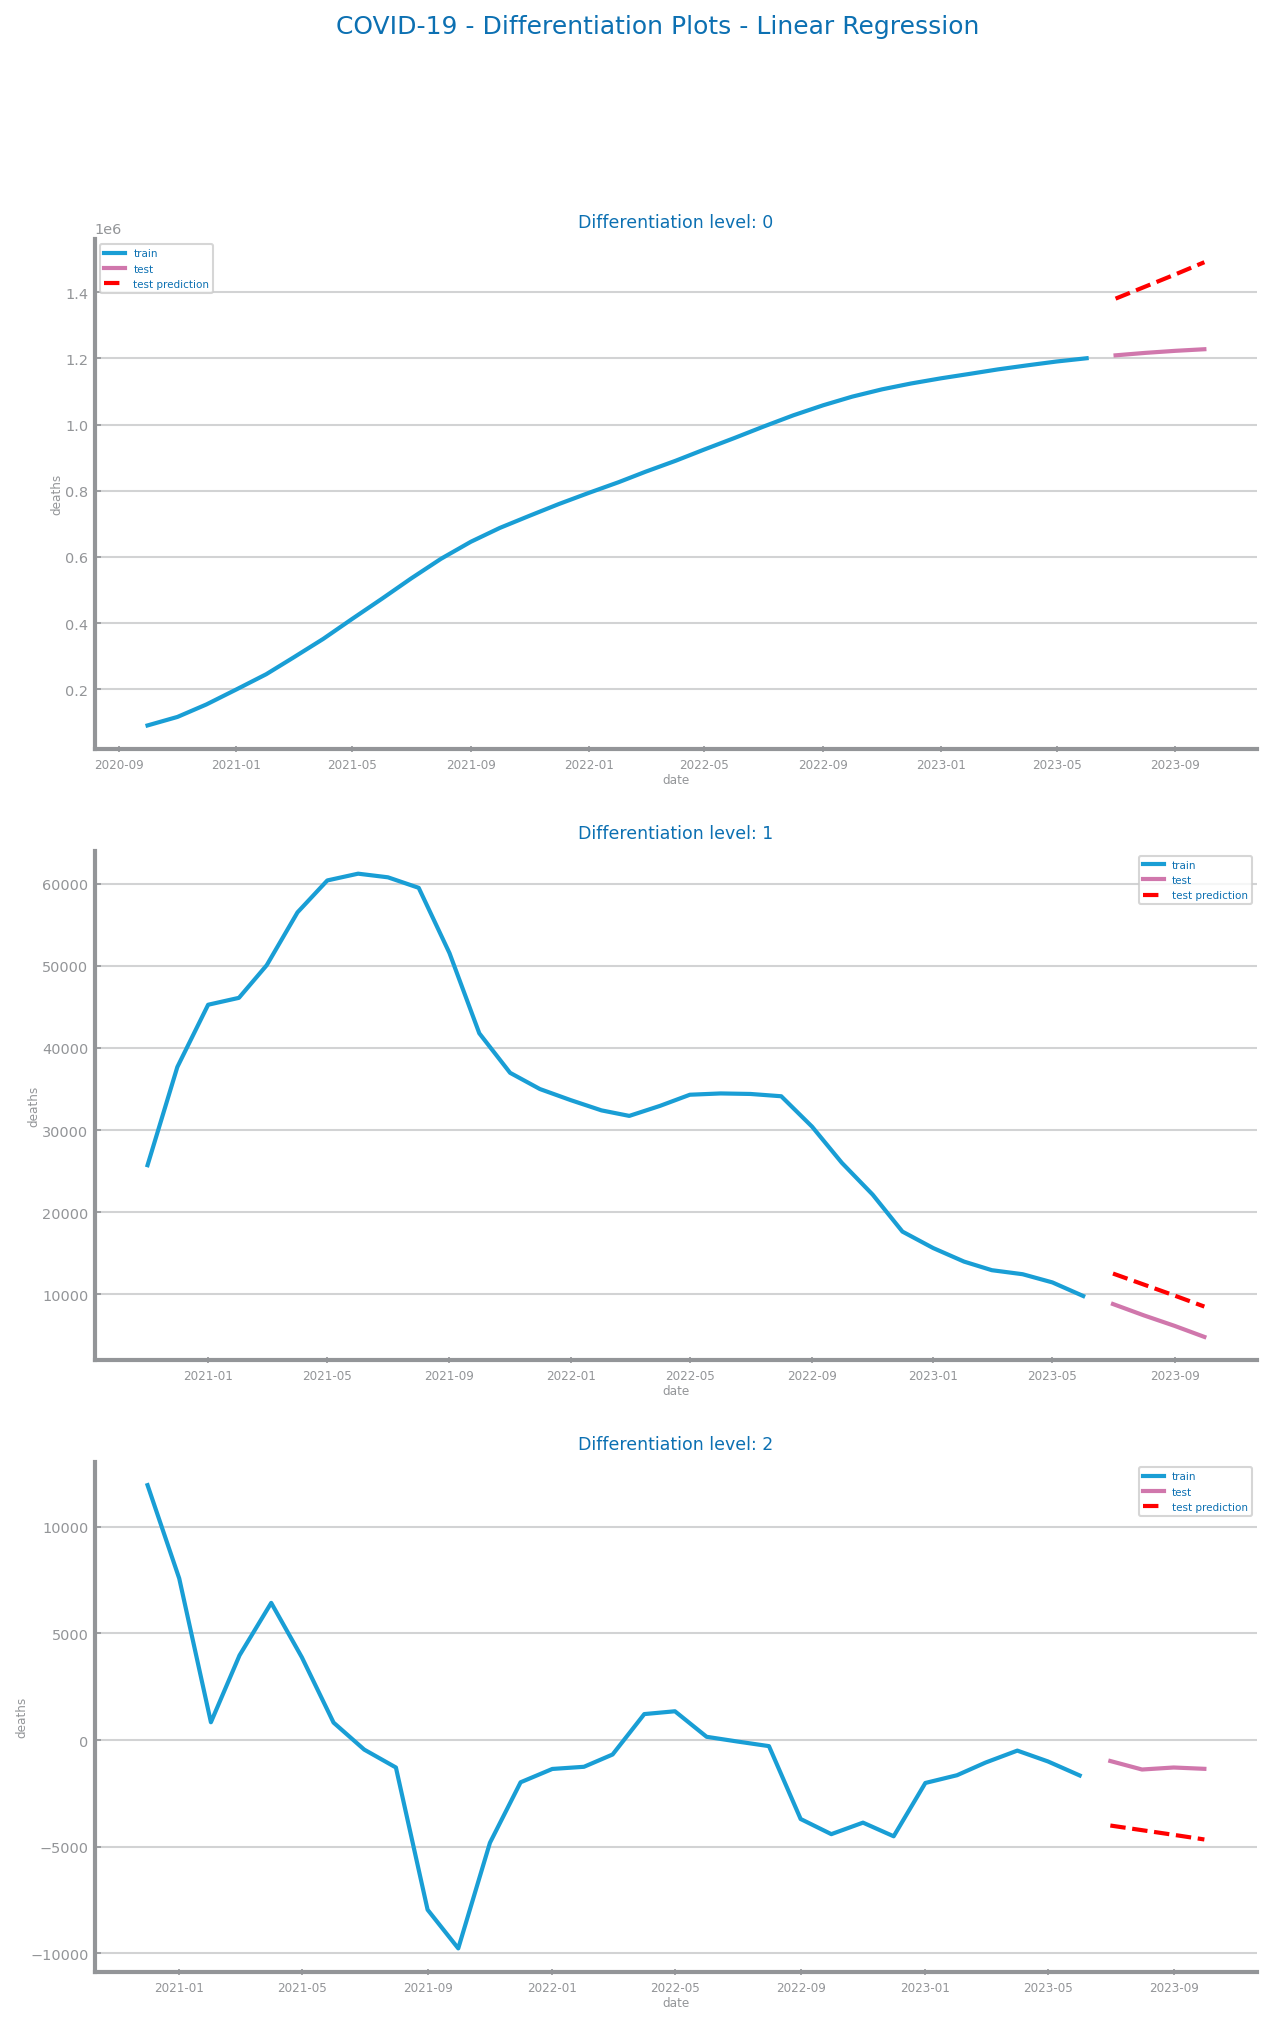

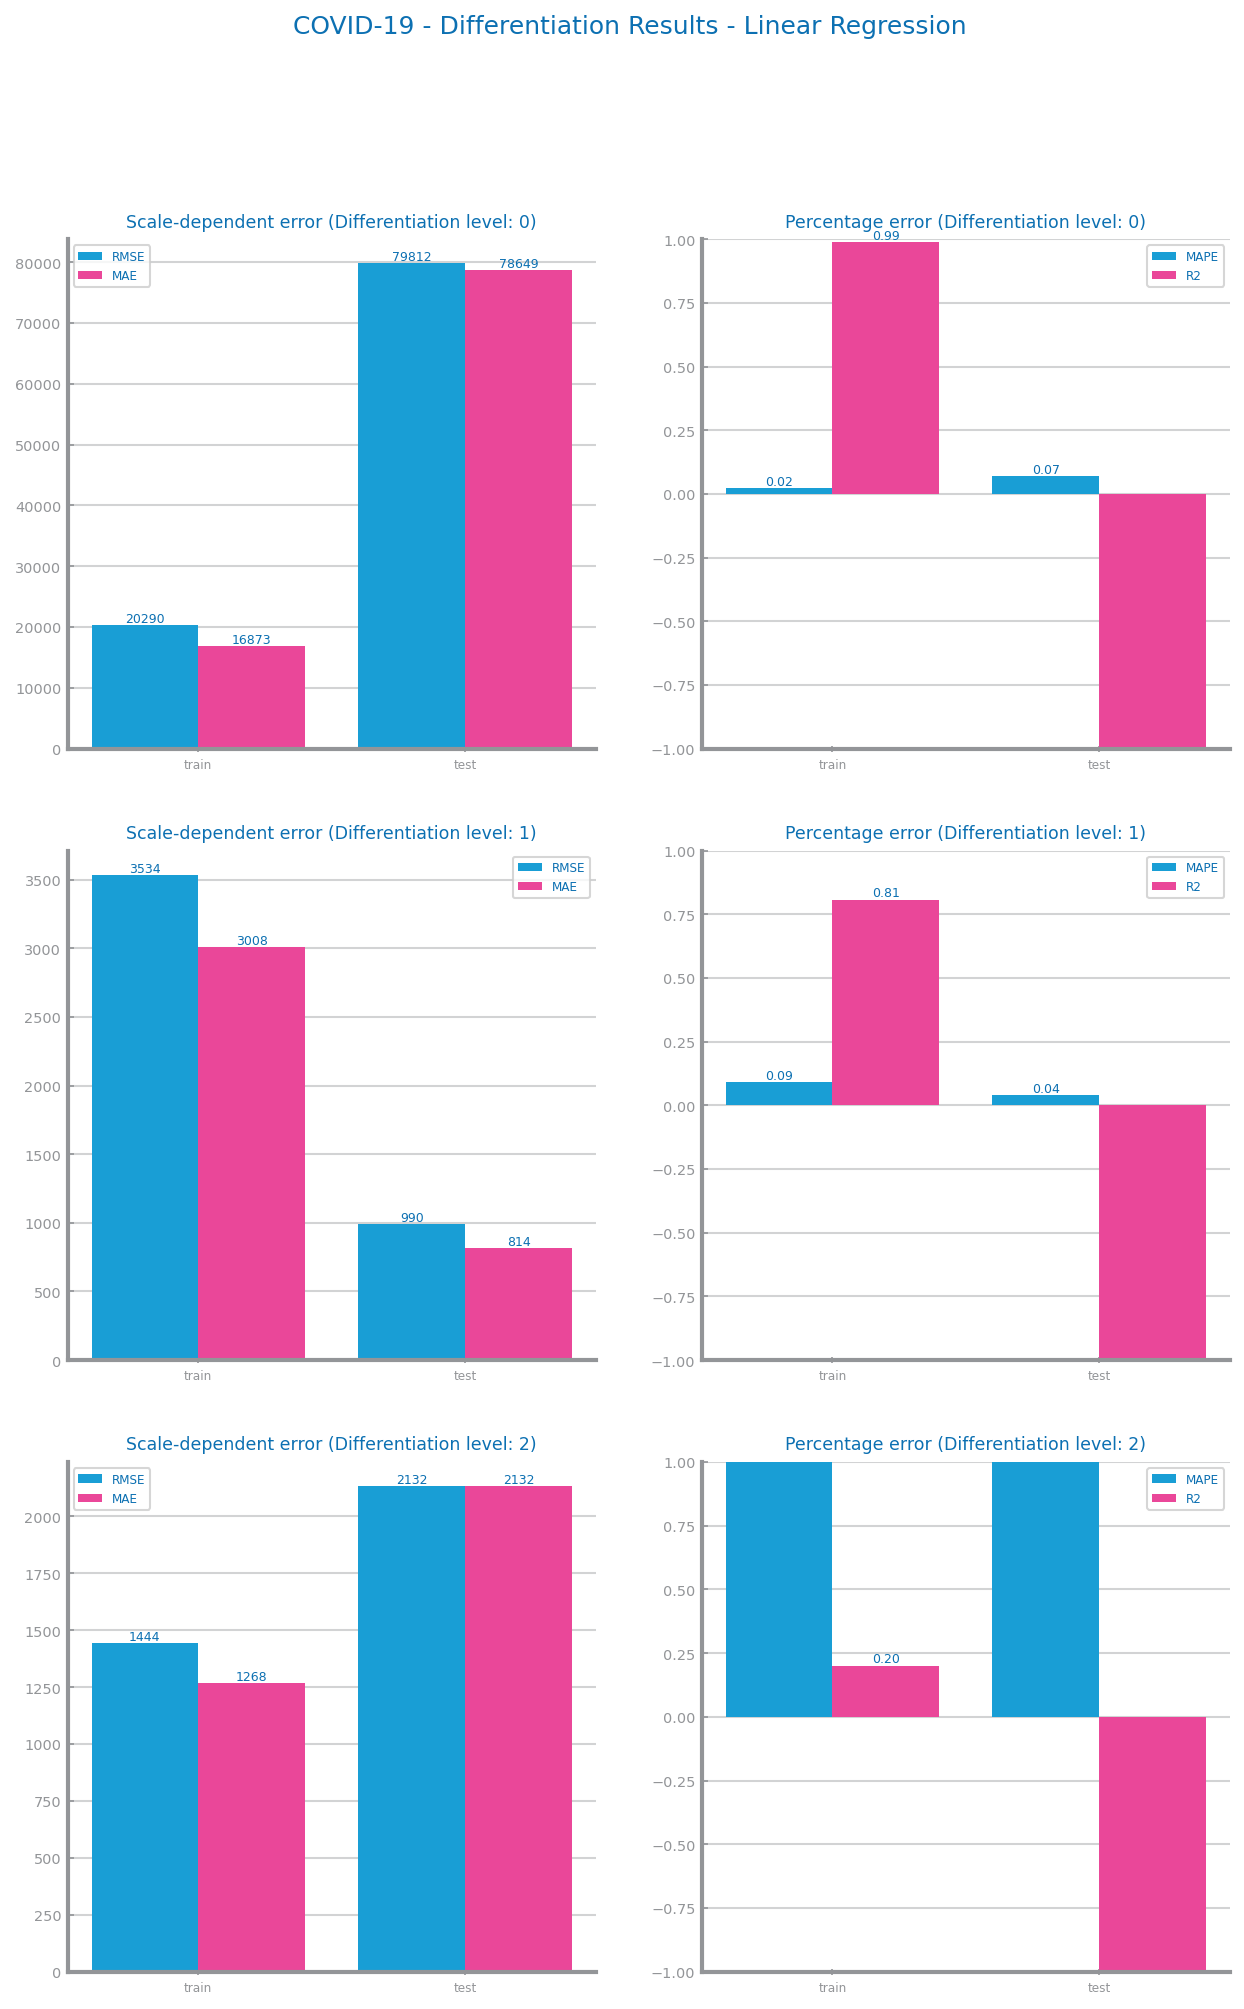

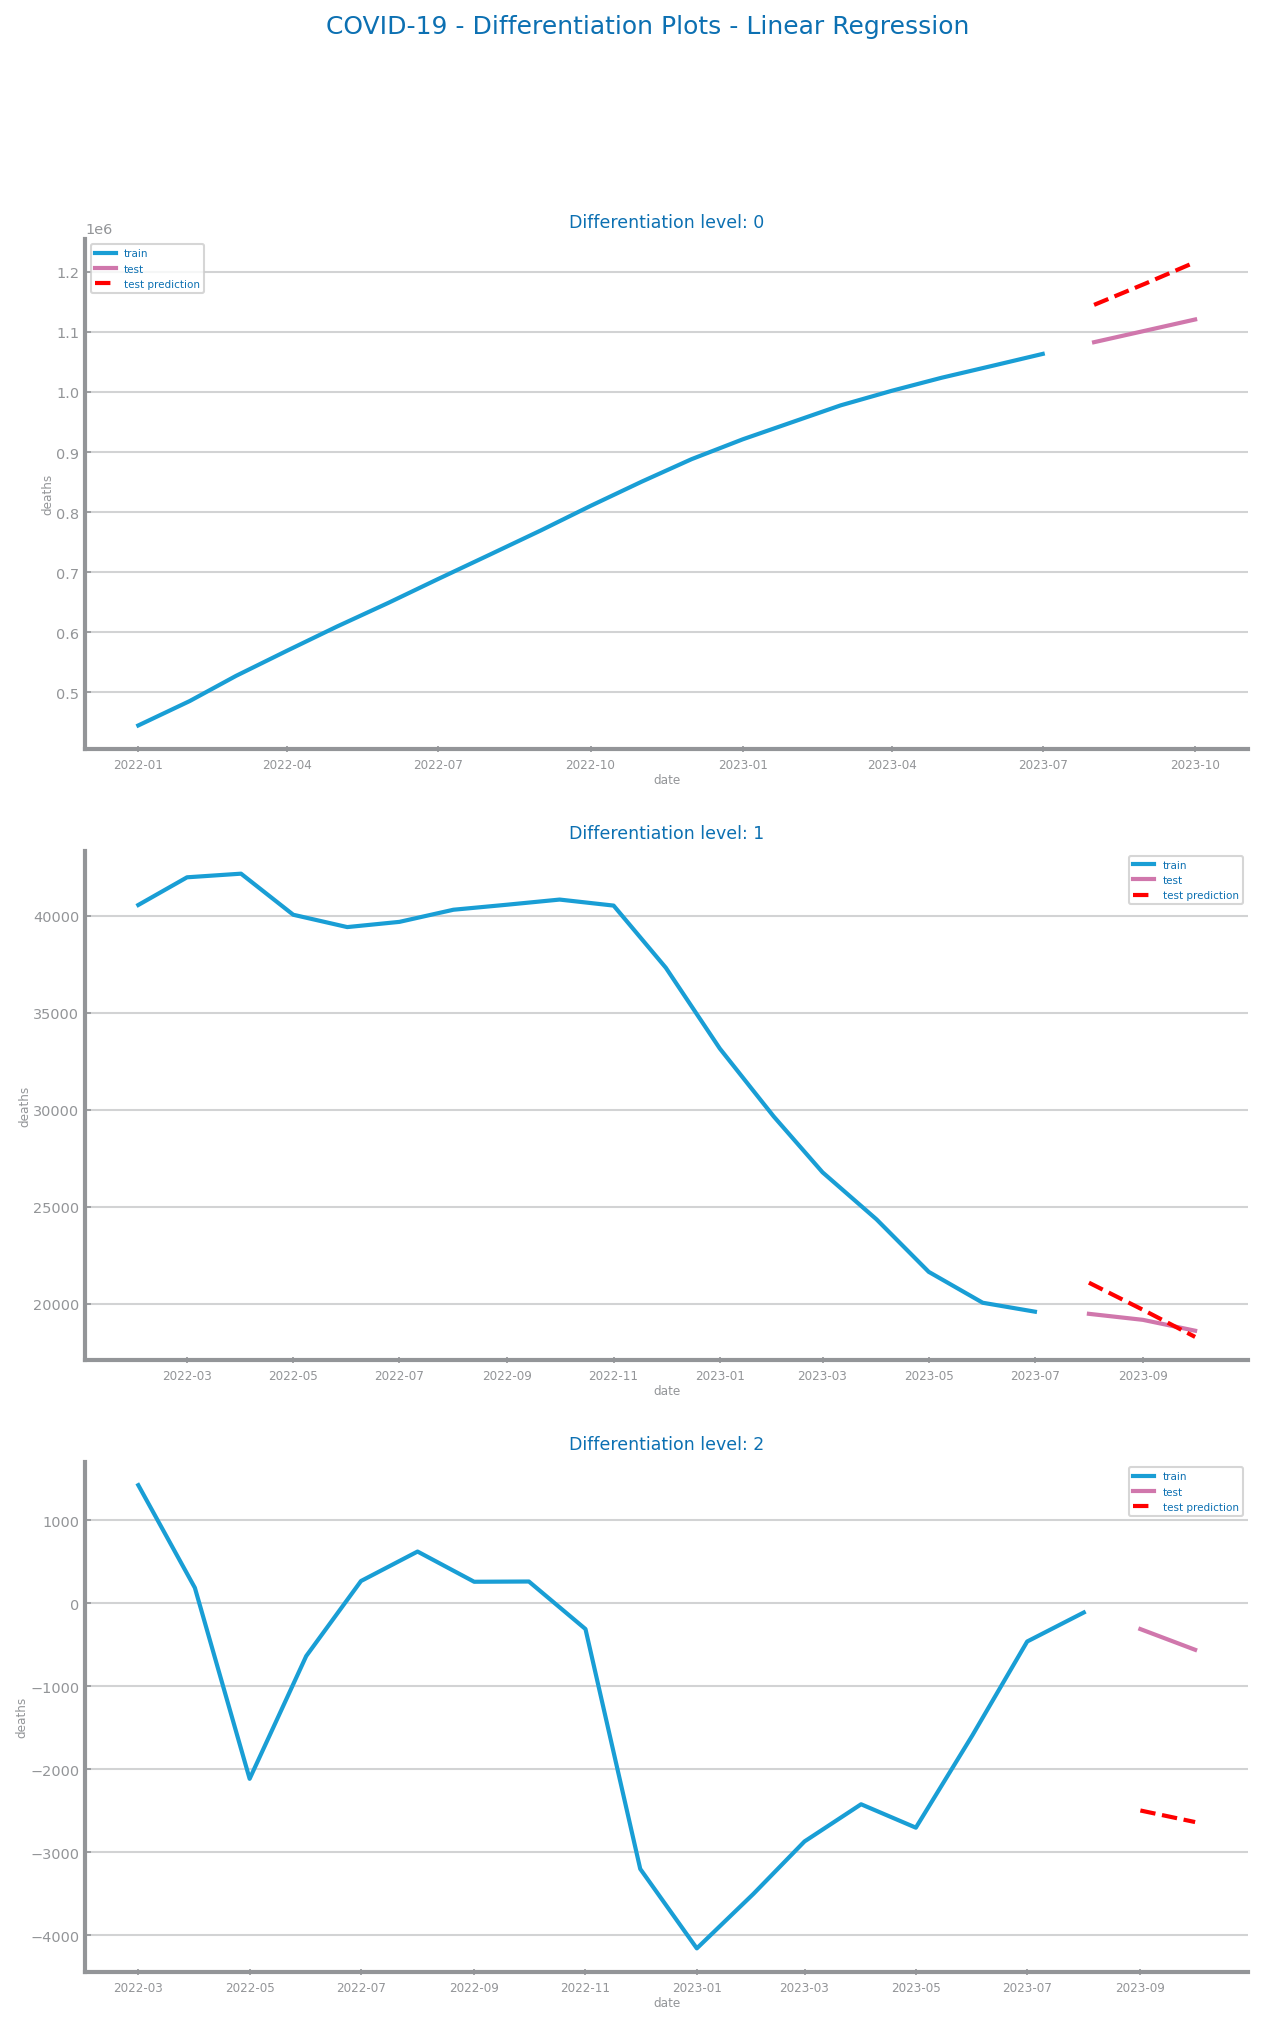

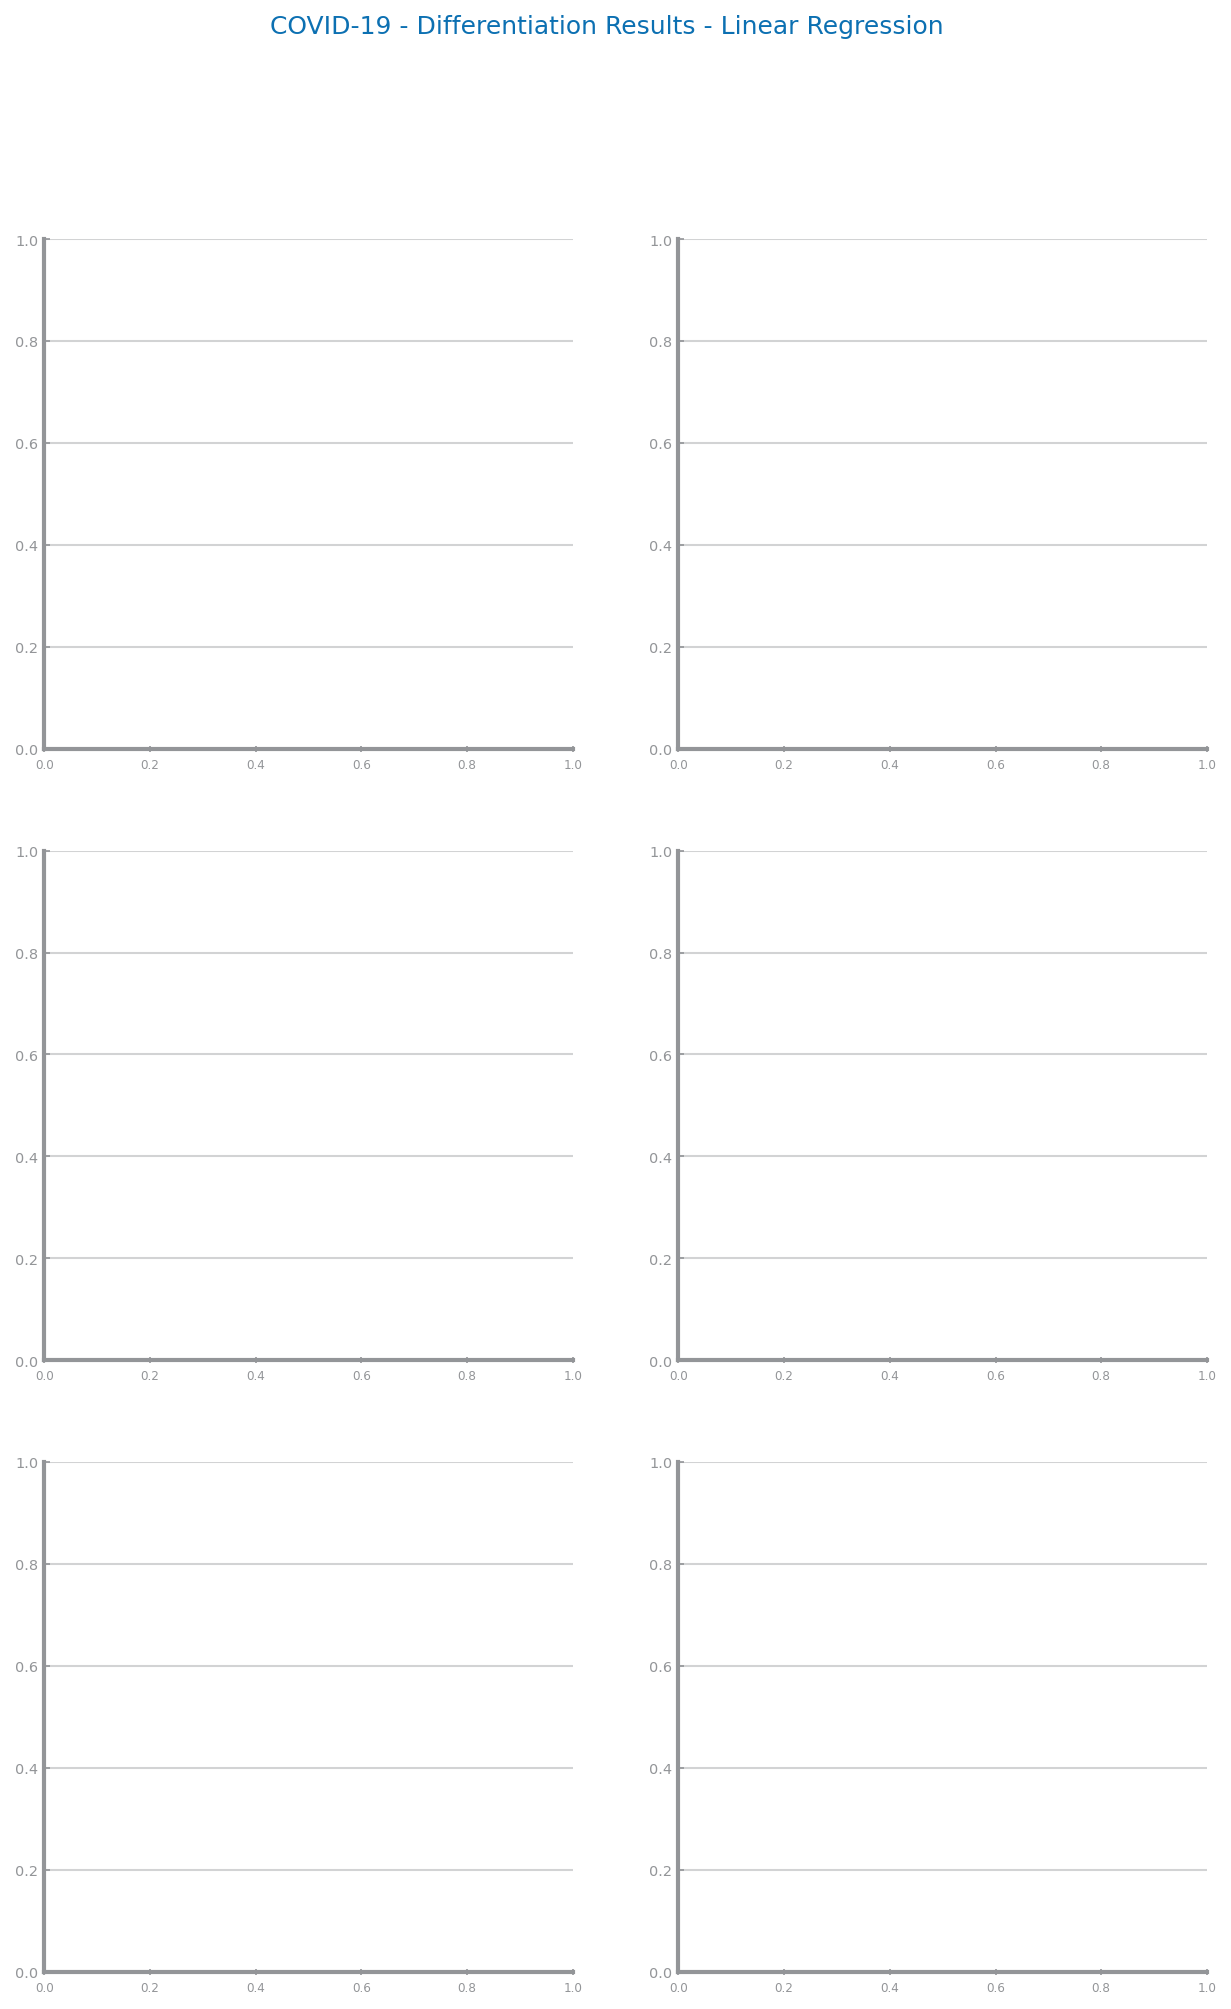

In [14]:
from numpy import arange
from pandas import read_csv, DataFrame, Series
from matplotlib.pyplot import savefig
from sklearn.linear_model import LinearRegression
from dslabs_functions import series_train_test_split, ts_aggregation_by

from matplotlib.pyplot import subplots
from matplotlib.axes import Axes
from matplotlib.figure import Figure

fig: Figure
axs: list[Axes]

## bests W, 50
## Q, 10

sizes: list[int] = [0, 1, 2]

for aggr in ["W", "M", "Q"]:
    agg_df: DataFrame = ts_aggregation_by(data, gran_level=aggr, agg_func="mean")
    for roll in [10, 25, 50, 75, 100]:

        fig, axs = subplots(nrows=3, ncols=2, figsize=(10, 15))
        fig.suptitle(f"{file_tag} - Differentiation Results - Linear Regression")
        scrt = agg_df.rolling(window=roll).mean()
        for i in range(len(sizes)):
            if sizes[i] != 0:
                scrt = scrt.diff()

            # scrt.fillna(0, inplace=True)
            scrt = scrt.dropna()
            
            
            train, test, prd_trn, prd_tst = bla(scrt)
            plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"Differentiation level: {sizes[i]}", axs=axs[i])
        savefig(f"images/{file_tag}_linear_regression_eval_{aggr}_{roll}.png", bbox_inches='tight')


        fig, axs = subplots(nrows=3, ncols=1, figsize=(10, 15))
        fig.suptitle(f"{file_tag} - Differentiation Plots - Linear Regression")
        scrt = agg_df.rolling(window=roll).mean()
        for i in range(len(sizes)):

            if sizes[i] != 0:
                scrt = scrt.diff()

            # scrt.fillna(0, inplace=True)
            scrt = scrt.dropna()

            train, test, prd_trn, prd_tst = bla(scrt)
            plot_forecasting_series(
                train,
                test,
                prd_tst,
                title=f"Differentiation level: {sizes[i]}",
                xlabel=timecol,
                ylabel=target,
                ax=axs[i]
            )
        savefig(f"images/{file_tag}_linear_regression_forecast_{aggr}_{roll}.png", bbox_inches='tight')
    #     break
    # break
